Simulating stars in parallel: 100%|██████████| 500/500 [00:18<00:00, 26.89it/s]


Simulated σ_R: 2.12 km/s
Theoretical σ_R: 2.23 km/s
Simulated σ_z: 0.95 km/s
Theoretical σ_z: 1.35 km/s


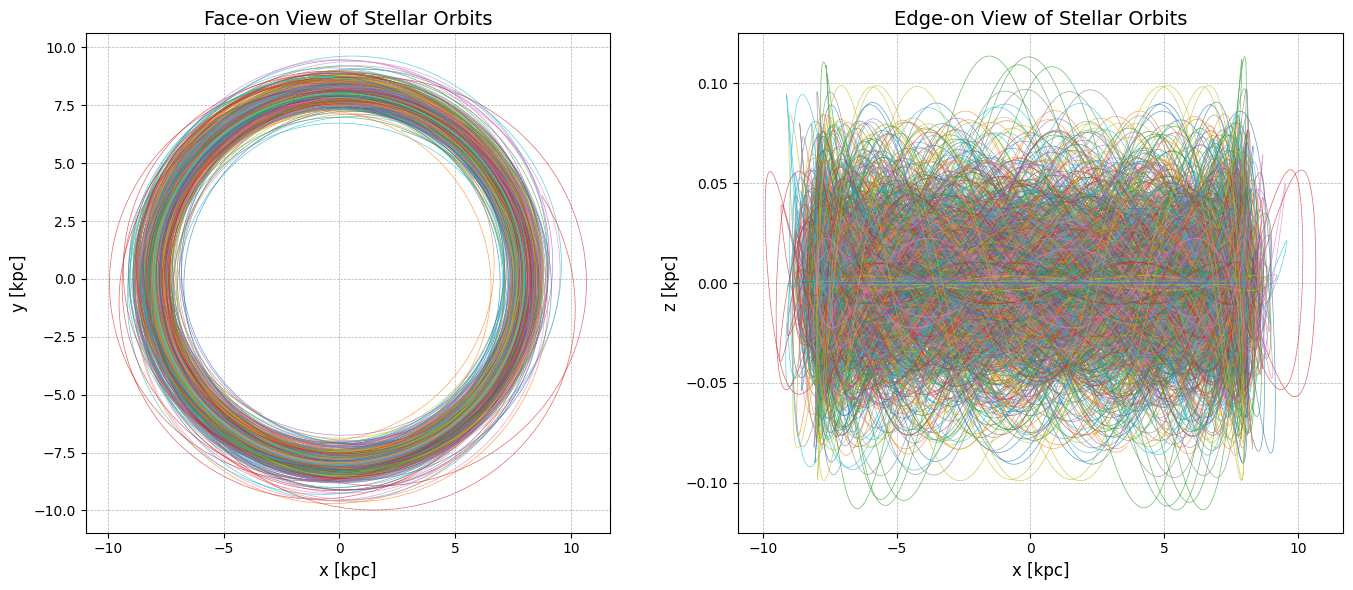

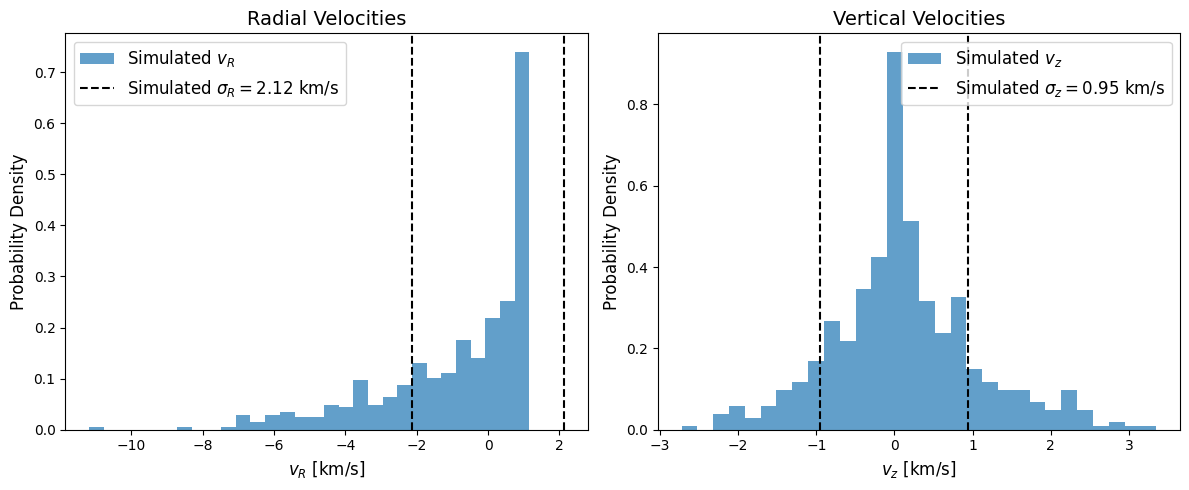

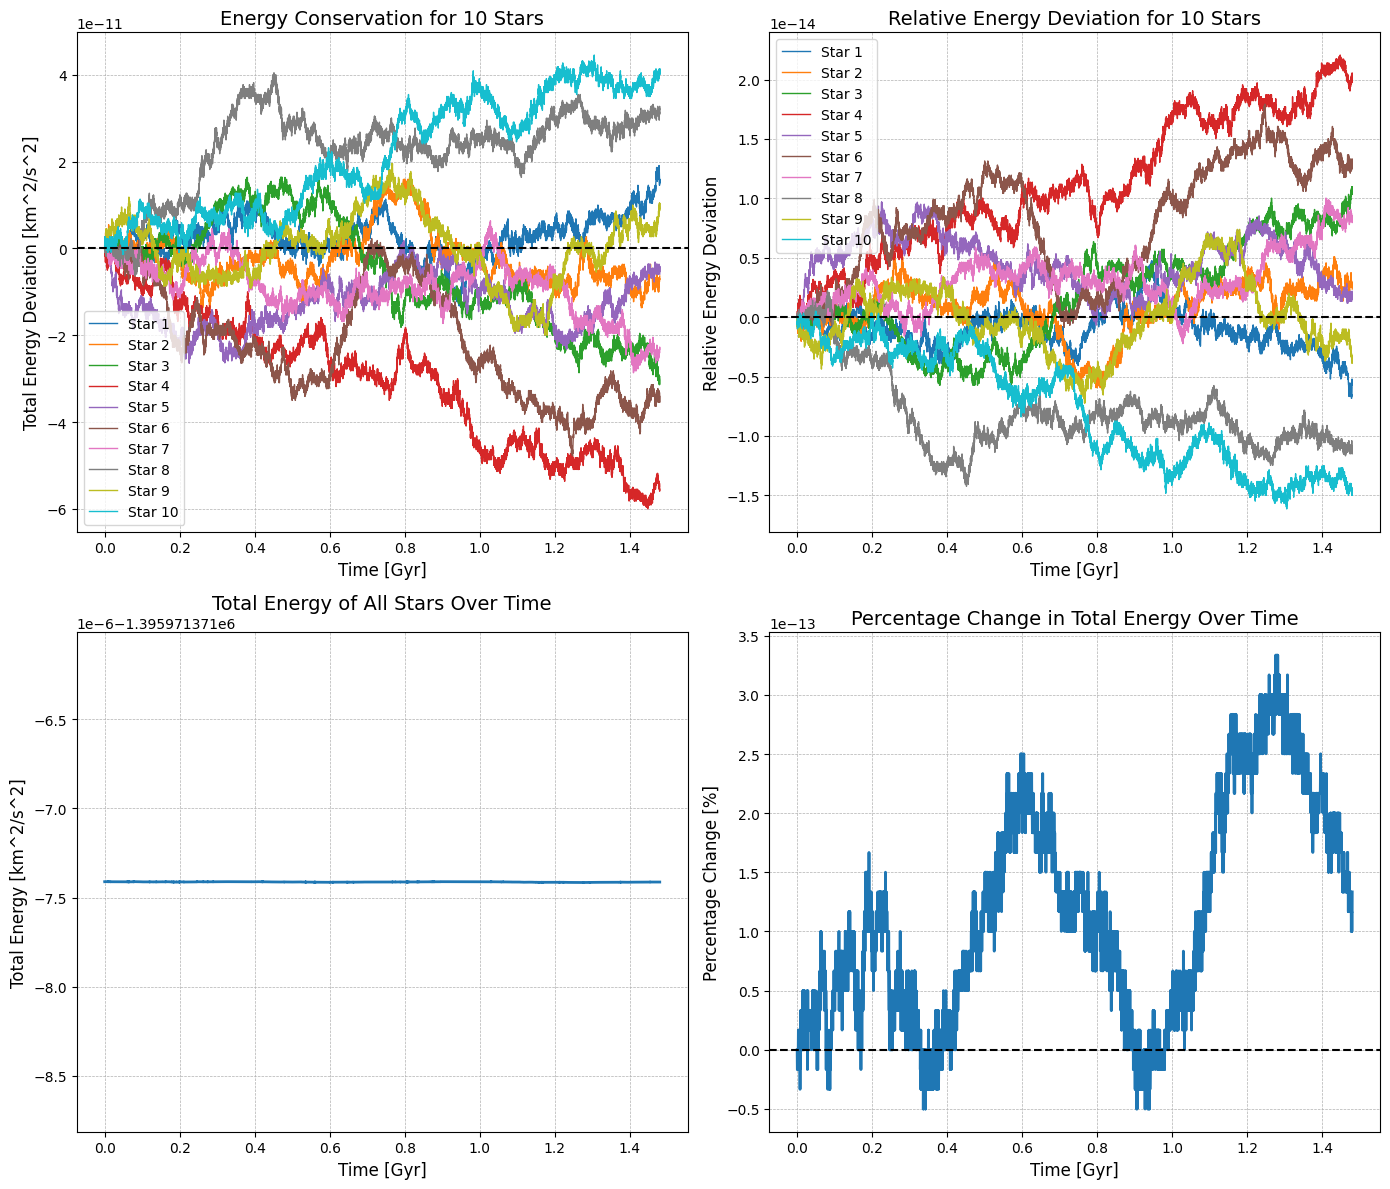

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# Physical constants
G = 4.30091e-6  # Gravitational constant in kpc (km/s)^2 Msun^{-1}

# Miyamoto-Nagai potential parameters
M = 1e10        # Msun, mass of the galaxy
a = 2.5         # kpc, radial scale length
b = a / 20      # kpc, vertical scale height

# Simulation parameters
alpha = 0.05    # Small parameter controlling epicyclic amplitude
R_c = 8.0       # kpc, reference radius (e.g., Solar circle)
num_stars = 500  # Number of stars to simulate
num_steps_per_orbit = 5000  # Integration steps per orbit
num_orbits = 2   # Number of orbits to simulate

# Define the Miyamoto-Nagai potential and its gradient
def potential(R, z):
    """Compute the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    return -G * M / S

def gradient_potential(R, z):
    """Compute the gradient of the potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    # Components of the gradient
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

# Define angular frequencies and epicyclic frequency
def Omega(R):
    """Compute the circular angular speed Omega at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    return np.sqrt(G * M / S**3)

def kappa(R):
    """Compute the epicyclic frequency kappa at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    Omega_sq = G * M / S**3
    R_over_S_sq = (R / S)**2
    kappa_sq = Omega_sq * (-3 * R_over_S_sq + 4)
    return np.sqrt(kappa_sq)

def gamma(R):
    """Compute gamma = 2 * Omega / kappa at radius R."""
    return 2 * Omega(R) / kappa(R)

# Velocity dispersion functions
def sigma_R_squared(R):
    """Compute sigma_R^2 using Eq. (8)."""
    kappa_R = kappa(R)
    return (kappa_R * alpha * R)**2 / 3

def rho(R, z):
    """Compute the volume density at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    numerator = b**2 * M * (a * R**2 + (a + 3 * B) * (a + B)**2)
    denominator = 4 * np.pi * S**5 * B**3
    return numerator / denominator

def sigma_z_squared(R):
    """Compute sigma_z^2 using Eq. (10)."""
    return b**2 * G * rho(R, 0)

# Equations of motion
def derivatives(state):
    """Compute the time derivatives of the state variables."""
    x, y, z, vx, vy, vz = state
    R = np.sqrt(x**2 + y**2)
    if R == 0:
        # Avoid division by zero at R = 0
        ax = 0.0
        ay = 0.0
    else:
        dPhi_dR, dPhi_dz = gradient_potential(R, z)
        # Convert gradient to Cartesian coordinates
        ax = -dPhi_dR * (x / R)
        ay = -dPhi_dR * (y / R)
    az = -gradient_potential(R, z)[1]
    return np.array([vx, vy, vz, ax, ay, az])

# Custom 4th-order Runge-Kutta integrator
def rk4_step(state, dt):
    """Perform one Runge-Kutta 4th order step."""
    k1 = derivatives(state)
    k2 = derivatives(state + 0.5 * dt * k1)
    k3 = derivatives(state + 0.5 * dt * k2)
    k4 = derivatives(state + dt * k3)
    return state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def total_energy(state):
    """Compute the total energy (kinetic + potential) for a given state."""
    x, y, z, vx, vy, vz = state
    R = np.sqrt(x**2 + y**2)
    
    # Kinetic energy
    kinetic_energy = 0.5 * (vx**2 + vy**2 + vz**2)
    
    # Potential energy
    potential_energy = potential(R, z)
    
    # Total energy
    return kinetic_energy + potential_energy

# Generate initial conditions
Omega_c = Omega(R_c)
kappa_c = kappa(R_c)
gamma_c = gamma(R_c)
sigma_R2 = sigma_R_squared(R_c)
sigma_z2 = sigma_z_squared(R_c)
v_circ = Omega_c * R_c

# Lists to store initial velocities for dispersion calculation
# These will now store final velocities
v_R_all = []
v_z_all = []

# Lists to store positions for plotting
positions_all = []

# Lists to store energies
energy_all = []

# Function to simulate a single star
def simulate_star(i):
    # Random initial azimuthal angle
    phi = np.random.uniform(0, 2 * np.pi)
    x0 = R_c * np.cos(phi)
    y0 = R_c * np.sin(phi)
    z0 = 0.0  # Start in the plane

    # Draw velocities from normal distributions
    v_R = np.random.normal(0.0, np.sqrt(sigma_R2))
    v_z = np.random.normal(0.0, np.sqrt(sigma_z2))

    # Compute v_phi using the corrected relation
    v_phi = v_circ - (v_R / gamma_c)

    # Convert to Cartesian velocities
    vx0 = v_R * np.cos(phi) - v_phi * np.sin(phi)
    vy0 = v_R * np.sin(phi) + v_phi * np.cos(phi)
    vz0 = v_z

    # Ensure the star is on a bound orbit
    E = 0.5 * (v_R**2 + v_phi**2 + v_z**2) + potential(R_c, 0)
    if E >= 0:
        return None, None, None  # Skip unbound stars

    # Time parameters
    T_orbit = 2 * np.pi / Omega_c
    dt = T_orbit / num_steps_per_orbit
    num_steps = num_steps_per_orbit * num_orbits

    # Initialize arrays to store positions for plotting and energy
    positions = np.zeros((num_steps, 3))
    energy = np.zeros(num_steps)

    # Initial state vector
    state = np.array([x0, y0, z0, vx0, vy0, vz0])

    # Time integration loop
    for step in range(num_steps):
        positions[step] = state[:3]
        energy[step] = total_energy(state)  # Track energy
        state = rk4_step(state, dt)

    # Extract final velocities
    x_final, y_final, z_final, vx_final, vy_final, vz_final = state
    R_final = np.sqrt(x_final**2 + y_final**2)

    if R_final != 0:
        v_R_final = (x_final * vx_final + y_final * vy_final) / R_final
    else:
        v_R_final = 0.0  # Handle R = 0 case

    v_z_final = vz_final

    # Return the results with final velocities
    return positions, energy, (v_R_final, v_z_final)

# Parallel processing for the stars simulation
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(simulate_star)(i) for i in tqdm(range(num_stars), desc="Simulating stars in parallel")
)

# Filter out None results (unbound stars)
filtered_results = [(pos, en, vel) for pos, en, vel in results if pos is not None]

# Unzip the filtered results
positions_all, energy_all, velocities_all = zip(*filtered_results) if filtered_results else ([], [], [])

# Convert to arrays if there are any bound stars
if positions_all:
    positions_all = np.array(positions_all)
    energy_all = np.array(energy_all)
    velocities_all = np.array(velocities_all)
    
    # Extract velocity components
    v_R_all = velocities_all[:, 0]
    v_z_all = velocities_all[:, 1]
    
    # Compute the total energy for all stars at each time step
    total_energy_all_stars = np.sum(energy_all, axis=0)
    
    # Compute the percentage change in total energy from the start
    initial_total_energy = total_energy_all_stars[0]
    percentage_change_total_energy = 100 * (total_energy_all_stars - initial_total_energy) / initial_total_energy
    
    # Compute simulated dispersions using final velocities
    sigma_R_sim = np.std(v_R_all)
    sigma_z_sim = np.std(v_z_all)
    
    # Compute theoretical dispersions
    sigma_R_theory = np.sqrt(sigma_R2)
    sigma_z_theory = np.sqrt(sigma_z2)
    
    print(f"Simulated σ_R: {sigma_R_sim:.2f} km/s")
    print(f"Theoretical σ_R: {sigma_R_theory:.2f} km/s")
    print(f"Simulated σ_z: {sigma_z_sim:.2f} km/s")
    print(f"Theoretical σ_z: {sigma_z_theory:.2f} km/s")
    
    # Plotting the orbits (Face-on and Edge-on views)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Face-on view (x-y plane)
    for pos in positions_all:
        axes[0].plot(pos[:, 0], pos[:, 1], linewidth=0.5, alpha=0.7)
    axes[0].set_xlabel('x [kpc]', fontsize=12)
    axes[0].set_ylabel('y [kpc]', fontsize=12)
    axes[0].set_title('Face-on View of Stellar Orbits', fontsize=14)
    axes[0].set_aspect('equal')  # Keep aspect ratio equal for face-on view
    axes[0].grid(True, linestyle='--', linewidth=0.5)
    
    # Edge-on view (x-z plane)
    for pos in positions_all:
        axes[1].plot(pos[:, 0], pos[:, 2], linewidth=0.5, alpha=0.7)
    axes[1].set_xlabel('x [kpc]', fontsize=12)
    axes[1].set_ylabel('z [kpc]', fontsize=12)
    axes[1].set_title('Edge-on View of Stellar Orbits', fontsize=14)
    # Remove equal aspect ratio to prevent flatness
    axes[1].grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Plot histograms of final velocities
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(v_R_all, bins=30, density=True, alpha=0.7, label='Simulated $v_R$')
    plt.axvline(sigma_R_sim, color='k', linestyle='--', label=f'Simulated $σ_R = {sigma_R_sim:.2f}$ km/s')
    plt.axvline(-sigma_R_sim, color='k', linestyle='--')
    plt.title('Radial Velocities', fontsize=14)
    plt.xlabel('$v_R$ [km/s]', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.hist(v_z_all, bins=30, density=True, alpha=0.7, label='Simulated $v_z$')
    plt.axvline(sigma_z_sim, color='k', linestyle='--', label=f'Simulated $σ_z = {sigma_z_sim:.2f}$ km/s')
    plt.axvline(-sigma_z_sim, color='k', linestyle='--')
    plt.title('Vertical Velocities', fontsize=14)
    plt.xlabel('$v_z$ [km/s]', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Define angular speed at the reference radius R_c
    Omega_c = Omega(R_c)
    
    # Define orbital period
    T_orbit = 2 * np.pi / Omega_c
    
    # Plotting energy conservation
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot 1: Energy conservation for a subset of stars (top-left)
    for i in range(min(len(energy_all), 10)):  # Plot 10 stars for clarity
        num_steps = len(energy_all[i])  # Use the number of steps specific to this star
        time_i = np.linspace(0, num_orbits * T_orbit, num_steps)  # Create time array for this star
        axes[0, 0].plot(time_i, energy_all[i] - energy_all[i][0], label=f'Star {i+1}', linewidth=1)
    
    axes[0, 0].set_title("Energy Conservation for 10 Stars", fontsize=14)
    axes[0, 0].set_xlabel("Time [Gyr]", fontsize=12)
    axes[0, 0].set_ylabel("Total Energy Deviation [km^2/s^2]", fontsize=12)
    axes[0, 0].grid(True, linestyle='--', linewidth=0.5)
    axes[0, 0].axhline(0, color='k', linestyle='--')  # Reference line for perfect conservation
    axes[0, 0].legend(fontsize=10)
    
    # Plot 2: Relative energy deviation for 10 stars (top-right)
    for i in range(min(len(energy_all), 10)):  # Plot 10 stars for clarity
        num_steps = len(energy_all[i])  # Use the number of steps specific to this star
        time_i = np.linspace(0, num_orbits * T_orbit, num_steps)  # Create time array for this star
        relative_energy_deviation = (energy_all[i] - energy_all[i][0]) / energy_all[i][0]
        axes[0, 1].plot(time_i, relative_energy_deviation, label=f'Star {i+1}', linewidth=1)
    
    axes[0, 1].set_title("Relative Energy Deviation for 10 Stars", fontsize=14)
    axes[0, 1].set_xlabel("Time [Gyr]", fontsize=12)
    axes[0, 1].set_ylabel("Relative Energy Deviation", fontsize=12)
    axes[0, 1].grid(True, linestyle='--', linewidth=0.5)
    axes[0, 1].axhline(0, color='k', linestyle='--')  # Reference line for no deviation
    axes[0, 1].legend(fontsize=10)
    
    # Plot 3: Total energy of all stars over time (bottom-left)
    num_steps = len(total_energy_all_stars)
    time = np.linspace(0, num_orbits * T_orbit, num_steps)  # Time array for all stars
    axes[1, 0].plot(time, total_energy_all_stars, label='Total Energy', linewidth=2)
    axes[1, 0].set_title("Total Energy of All Stars Over Time", fontsize=14)
    axes[1, 0].set_xlabel("Time [Gyr]", fontsize=12)
    axes[1, 0].set_ylabel("Total Energy [km^2/s^2]", fontsize=12)
    axes[1, 0].grid(True, linestyle='--', linewidth=0.5)
    
    # Plot 4: Percentage change in total energy over time (bottom-right)
    axes[1, 1].plot(time, percentage_change_total_energy, label='% Change in Total Energy', linewidth=2)
    axes[1, 1].set_title("Percentage Change in Total Energy Over Time", fontsize=14)
    axes[1, 1].set_xlabel("Time [Gyr]", fontsize=12)
    axes[1, 1].set_ylabel("Percentage Change [%]", fontsize=12)
    axes[1, 1].grid(True, linestyle='--', linewidth=0.5)
    axes[1, 1].axhline(0, color='k', linestyle='--')  # Reference line for no change
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
else:
    print("No bound stars were simulated.")


Integrating the system with the perturber...


100%|██████████| 49999/49999 [00:17<00:00, 2883.83it/s]


Simulated σ_R: 47.93 km/s
Theoretical σ_R: 2.23 km/s
Simulated σ_z: 1.30 km/s
Theoretical σ_z: 1.35 km/s


/var/folders/zk/d5jm9r5917796y8g9xs4mt400000gn/T/ipykernel_14496/2280670495.py:342: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



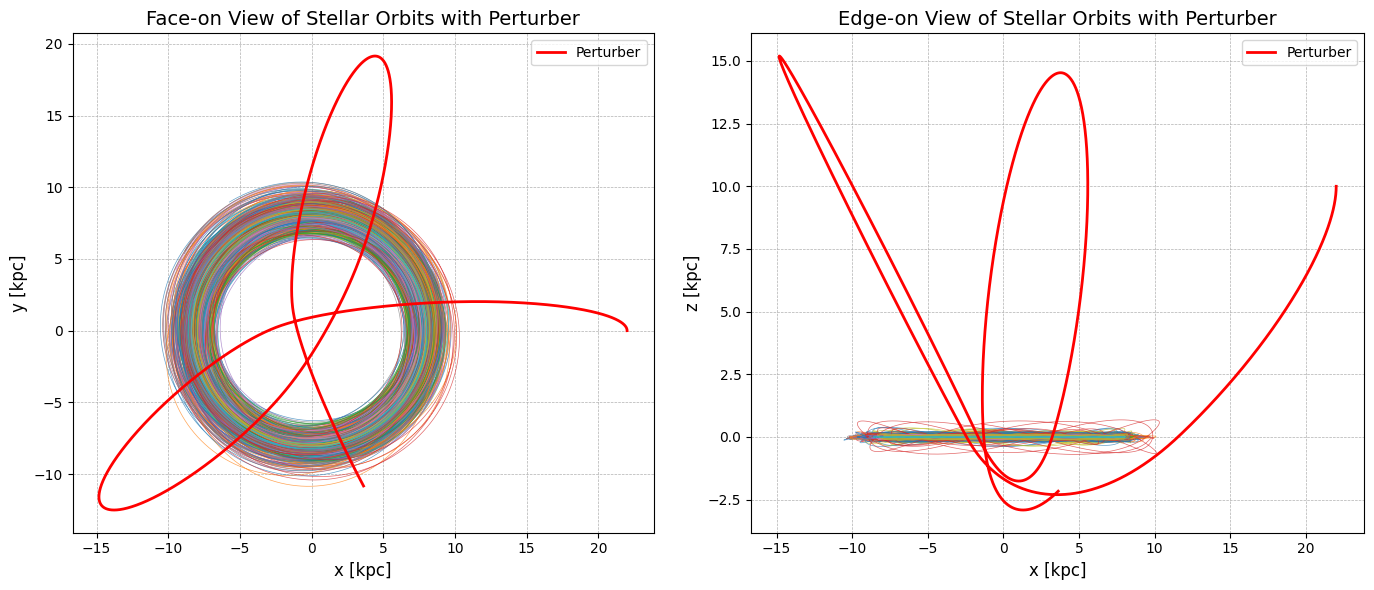

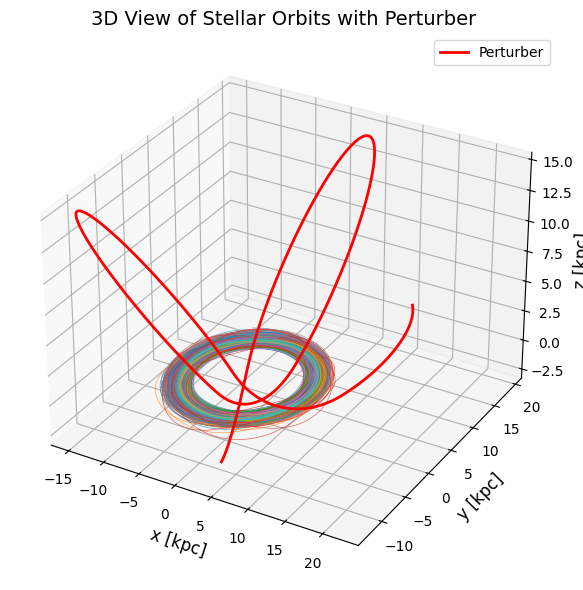

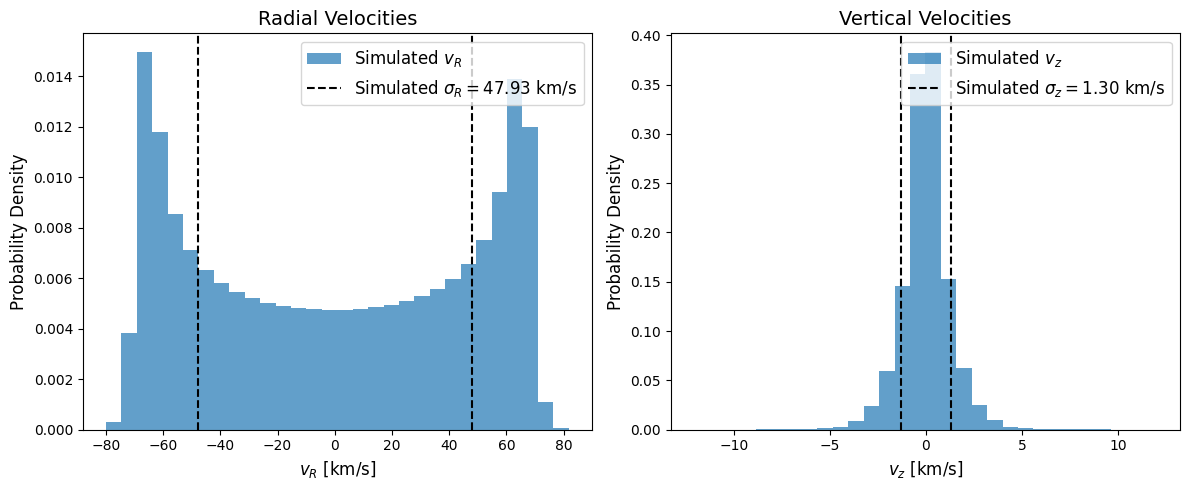

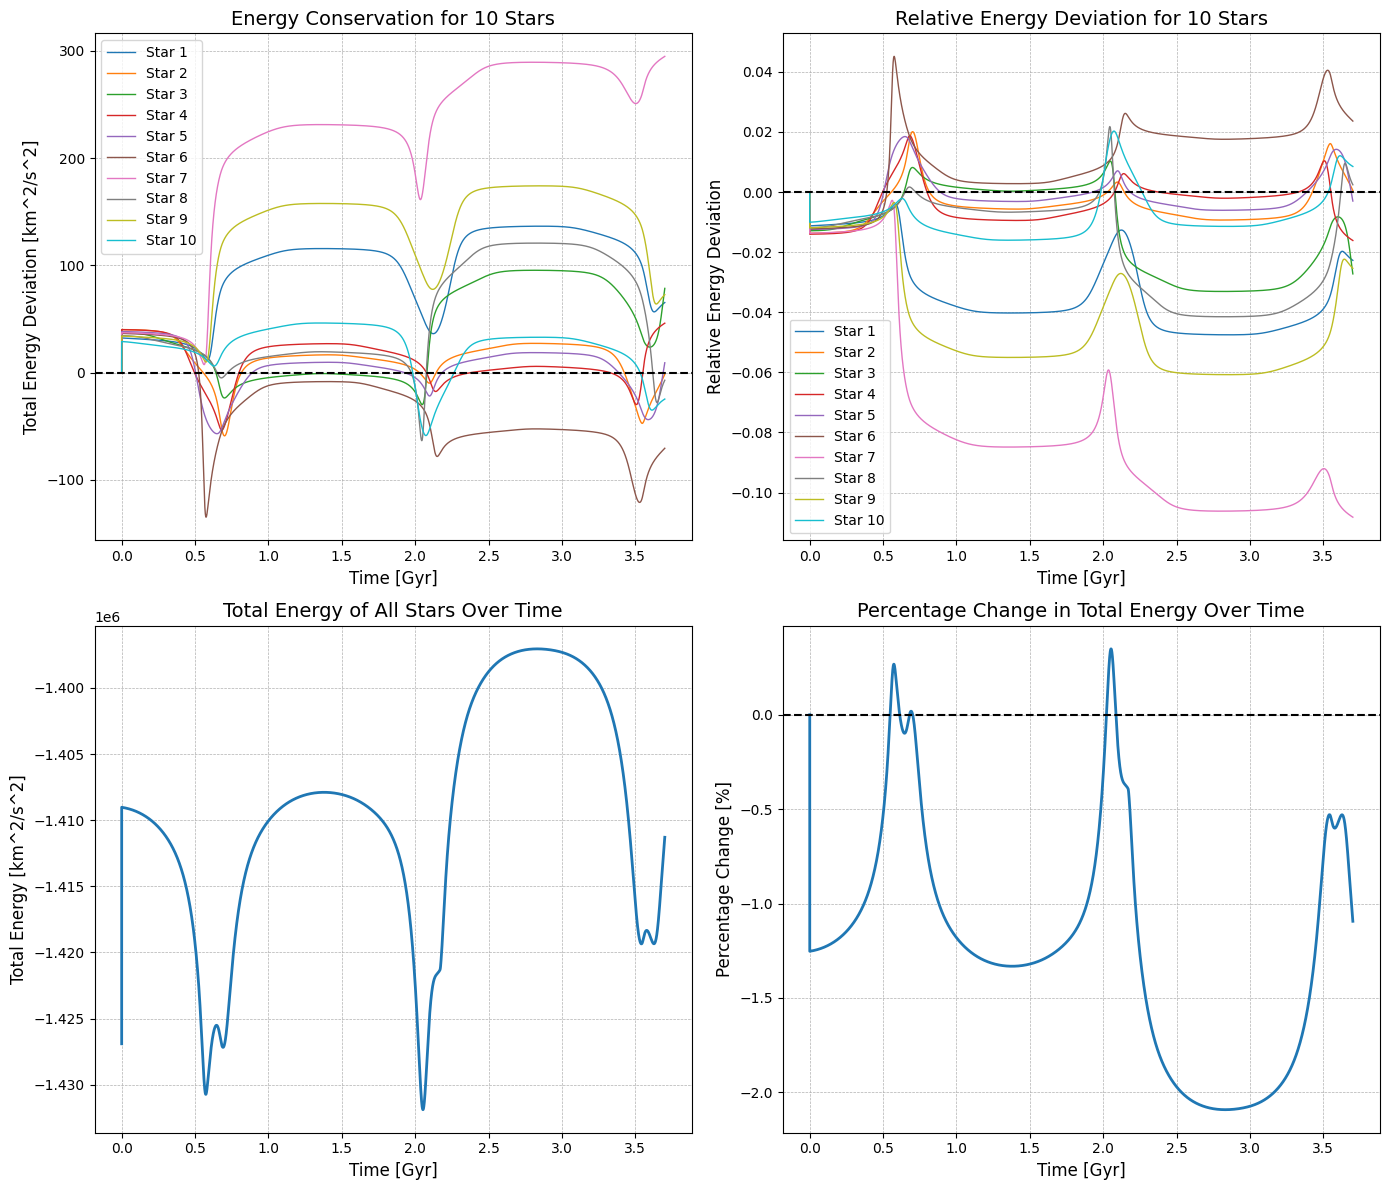

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Physical constants
G = 4.30091e-6  # Gravitational constant in kpc (km/s)^2 Msun^{-1}

# Miyamoto-Nagai potential parameters
M = 1e10        # Msun, mass of the galaxy
a = 2.5         # kpc, radial scale length
b = a / 20      # kpc, vertical scale height

# Perturber parameters
MBH = 1e8       # Msun, mass of the perturber
epsilon = 0.01   # kpc, softening length to avoid singularities

# Simulation parameters
alpha = 0.05    # Small parameter controlling epicyclic amplitude
R_c = 8.0       # kpc, reference radius (e.g., Solar circle)
num_stars = 500  # Number of stars to simulate
num_steps_per_orbit = 10000  # Integration steps per orbit
num_orbits = 5   # Number of orbits to simulate

# Time parameters
Omega_c = np.sqrt(G * M / (R_c**2 + (a + b)**2)**(1.5))
T_orbit = 2 * np.pi / Omega_c
dt = T_orbit / num_steps_per_orbit
num_steps = int(num_steps_per_orbit * num_orbits)

# Define the Miyamoto-Nagai potential and its gradient
def potential(R, z):
    """Compute the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    return -G * M / S

def gradient_potential(R, z):
    """Compute the gradient of the potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    # Components of the gradient
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

def gradient_potential_vectorized(R, z):
    """Compute the gradient of the potential at positions (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

# Define angular frequencies and epicyclic frequency
def Omega(R):
    """Compute the circular angular speed Omega at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    return np.sqrt(G * M / S**3)

def kappa(R):
    """Compute the epicyclic frequency kappa at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    Omega_sq = G * M / S**3
    R_over_S_sq = (R / S)**2
    kappa_sq = Omega_sq * (-3 * R_over_S_sq + 4)
    return np.sqrt(kappa_sq)

def gamma(R):
    """Compute gamma = 2 * Omega / kappa at radius R."""
    return 2 * Omega(R) / kappa(R)

# Velocity dispersion functions
def sigma_R_squared(R):
    """Compute sigma_R^2 using Eq. (8)."""
    kappa_R = kappa(R)
    return (kappa_R * alpha * R)**2 / 3

def rho(R, z):
    """Compute the volume density at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    numerator = b**2 * M * (a * R**2 + (a + 3 * B) * (a + B)**2)
    denominator = 4 * np.pi * S**5 * B**3
    return numerator / denominator

def sigma_z_squared(R):
    """Compute sigma_z^2 using Eq. (10)."""
    return b**2 * G * rho(R, 0)

# Equations of motion for the perturber
def derivatives_perturber(state):
    """Compute the time derivatives of the perturber's state variables."""
    x, y, z, vx, vy, vz = state
    R = np.sqrt(x**2 + y**2)
    if R == 0:
        # Avoid division by zero at R = 0
        ax = 0.0
        ay = 0.0
    else:
        dPhi_dR, dPhi_dz = gradient_potential(R, z)
        # Convert gradient to Cartesian coordinates
        ax = -dPhi_dR * (x / R)
        ay = -dPhi_dR * (y / R)
    az = -gradient_potential(R, z)[1]
    return np.array([vx, vy, vz, ax, ay, az])

# Equations of motion for the stars
def derivatives_stars(states, state_BH):
    """Compute the time derivatives of the stars' state variables."""
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    vx = states[:, 3]
    vy = states[:, 4]
    vz = states[:, 5]
    R = np.sqrt(x**2 + y**2)

    dPhi_dR, dPhi_dz = gradient_potential_vectorized(R, z)

    # Avoid division by zero at R = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        x_over_R = np.where(R != 0, x / R, 0)
        y_over_R = np.where(R != 0, y / R, 0)
        ax = -dPhi_dR * x_over_R
        ay = -dPhi_dR * y_over_R

    az = -dPhi_dz

    # Compute acceleration due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2
    r_BH = np.sqrt(r_BH_sq)

    with np.errstate(divide='ignore', invalid='ignore'):
        inv_r3 = 1.0 / (r_BH_sq * r_BH)
        a_BH_x = -G * MBH * dx * inv_r3
        a_BH_y = -G * MBH * dy * inv_r3
        a_BH_z = -G * MBH * dz * inv_r3

    # Total accelerations
    ax_total = ax + a_BH_x
    ay_total = ay + a_BH_y
    az_total = az + a_BH_z

    derivatives = np.zeros_like(states)
    derivatives[:, 0] = vx
    derivatives[:, 1] = vy
    derivatives[:, 2] = vz
    derivatives[:, 3] = ax_total
    derivatives[:, 4] = ay_total
    derivatives[:, 5] = az_total

    return derivatives

# Custom 4th-order Runge-Kutta integrator for arrays
def rk4_step_array(states, dt, derivs_func, state_BH):
    """Perform one Runge-Kutta 4th order step for arrays."""
    k1 = derivs_func(states, state_BH)
    k2 = derivs_func(states + 0.5 * dt * k1, state_BH)
    k3 = derivs_func(states + 0.5 * dt * k2, state_BH)
    k4 = derivs_func(states + dt * k3, state_BH)
    return states + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Custom 4th-order Runge-Kutta integrator for the perturber
def rk4_step(state, dt, derivs_func):
    """Perform one Runge-Kutta 4th order step for the perturber."""
    k1 = derivs_func(state)
    k2 = derivs_func(state + 0.5 * dt * k1)
    k3 = derivs_func(state + 0.5 * dt * k2)
    k4 = derivs_func(state + dt * k3)
    return state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def total_energy(states, state_BH):
    """Compute the total energy (kinetic + potential) for the stars."""
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    vx = states[:, 3]
    vy = states[:, 4]
    vz = states[:, 5]
    R = np.sqrt(x**2 + y**2)

    # Kinetic energy
    kinetic_energy = 0.5 * (vx**2 + vy**2 + vz**2)

    # Potential energy from Miyamoto-Nagai potential
    potential_energy = potential(R, z)

    # Potential energy due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2
    potential_energy_BH = -G * MBH / np.sqrt(r_BH_sq)

    total_energy = kinetic_energy + potential_energy + potential_energy_BH

    return total_energy

# Generate initial conditions for stars
Omega_c = Omega(R_c)
kappa_c = kappa(R_c)
gamma_c = gamma(R_c)
sigma_R2 = sigma_R_squared(R_c)
sigma_z2 = sigma_z_squared(R_c)
v_circ = Omega_c * R_c

# Initialize arrays for stars
x0 = np.zeros(num_stars)
y0 = np.zeros(num_stars)
z0 = np.zeros(num_stars)
vx0 = np.zeros(num_stars)
vy0 = np.zeros(num_stars)
vz0 = np.zeros(num_stars)

for i in range(num_stars):
    # Random initial azimuthal angle
    phi = np.random.uniform(0, 2 * np.pi)
    x0[i] = R_c * np.cos(phi)
    y0[i] = R_c * np.sin(phi)
    z0[i] = 0.0  # Start in the plane

    # Draw velocities from normal distributions
    v_R = np.random.normal(0.0, np.sqrt(sigma_R2))
    v_z = np.random.normal(0.0, np.sqrt(sigma_z2))

    # Compute v_phi using the corrected relation
    v_phi = v_circ - (v_R / gamma_c)

    # Convert to Cartesian velocities
    vx0[i] = v_R * np.cos(phi) - v_phi * np.sin(phi)
    vy0[i] = v_R * np.sin(phi) + v_phi * np.cos(phi)
    vz0[i] = v_z

# Initial state arrays for stars
states = np.zeros((num_stars, 6))
states[:, 0] = x0
states[:, 1] = y0
states[:, 2] = z0
states[:, 3] = vx0
states[:, 4] = vy0
states[:, 5] = vz0

# Initial energies
initial_energies = total_energy(states, np.zeros(6))

# Initialize arrays to store positions, velocities, and energies
positions = np.zeros((num_steps, num_stars, 3))
velocities = np.zeros((num_steps, num_stars, 3))
energies = np.zeros((num_steps, num_stars))

# Store initial positions and energies
positions[0, :, :] = states[:, :3]
velocities[0, :, :] = states[:, 3:6]
energies[0, :] = initial_energies

# Adjusted initial conditions for the perturber
x_BH0 = 22
y_BH0 = 0.0
z_BH0 = 10.0  # Start above the disk
vx_BH0 = 0.0
vy_BH0 = 5.0  # For orthogonal passage, set vy_BH0 = 0.0
vz_BH0 = -10.0  # km/s, increased speed for timely interaction

# State vector for the perturber
state_BH = np.array([x_BH0, y_BH0, z_BH0, vx_BH0, vy_BH0, vz_BH0])

# Initialize array to store perturber's positions
perturber_positions = np.zeros((num_steps, 3))
perturber_positions[0] = state_BH[:3]  # Initial position

# Time integration loop
print("Integrating the system with the perturber...")
for t in tqdm(range(1, num_steps)):
    # Update the perturber's state
    state_BH = rk4_step(state_BH, dt, derivatives_perturber)
    
    # Store the perturber's position
    perturber_positions[t] = state_BH[:3]
    
    # Update the stars' states
    states = rk4_step_array(states, dt, derivatives_stars, state_BH)
    
    # Store positions, velocities, and energies
    positions[t, :, :] = states[:, :3]
    velocities[t, :, :] = states[:, 3:6]
    energies[t, :] = total_energy(states, state_BH)

# Compute the total energy of all stars over time
total_energy_all_stars = np.sum(energies, axis=1)

# Compute the percentage change in total energy from the start
initial_total_energy = total_energy_all_stars[0]
percentage_change_total_energy = 100 * (total_energy_all_stars - initial_total_energy) / initial_total_energy

# Extract all velocities for dispersion calculation
v_R_all = velocities[:, :, 0].flatten()
v_z_all = velocities[:, :, 2].flatten()

# Compute simulated dispersions
sigma_R_sim = np.std(v_R_all)
sigma_z_sim = np.std(v_z_all)

# Compute theoretical dispersions
sigma_R_theory = np.sqrt(sigma_R2)
sigma_z_theory = np.sqrt(sigma_z2)

print(f"Simulated σ_R: {sigma_R_sim:.2f} km/s")
print(f"Theoretical σ_R: {sigma_R_theory:.2f} km/s")
print(f"Simulated σ_z: {sigma_z_sim:.2f} km/s")
print(f"Theoretical σ_z: {sigma_z_theory:.2f} km/s")

# Plotting the orbits (Face-on and Edge-on views)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Face-on view (x-y plane)
for i in range(num_stars):
    axes[0].plot(positions[:, i, 0], positions[:, i, 1], linewidth=0.5, alpha=0.7)
axes[0].plot(perturber_positions[:, 0], perturber_positions[:, 1], 'r-', linewidth=2, label='Perturber')
axes[0].set_xlabel('x [kpc]', fontsize=12)
axes[0].set_ylabel('y [kpc]', fontsize=12)
axes[0].set_title('Face-on View of Stellar Orbits with Perturber', fontsize=14)
axes[0].set_aspect('equal')
axes[0].grid(True, linestyle='--', linewidth=0.5)
axes[0].legend()

# Edge-on view (x-z plane)
for i in range(num_stars):
    axes[1].plot(positions[:, i, 0], positions[:, i, 2], linewidth=0.5, alpha=0.7)
axes[1].plot(perturber_positions[:, 0], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')
axes[1].set_xlabel('x [kpc]', fontsize=12)
axes[1].set_ylabel('z [kpc]', fontsize=12)
axes[1].set_title('Edge-on View of Stellar Orbits with Perturber', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

# 3D plot of the orbits (x, y, z for stars and perturber)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot star orbits in 3D
for i in range(num_stars):
    ax.plot(positions[:, i, 0], positions[:, i, 1], positions[:, i, 2], linewidth=0.5, alpha=0.7)

# Plot perturber's orbit in 3D
ax.plot(perturber_positions[:, 0], perturber_positions[:, 1], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')

# Set labels and title
ax.set_xlabel('x [kpc]', fontsize=12)
ax.set_ylabel('y [kpc]', fontsize=12)
ax.set_zlabel('z [kpc]', fontsize=12)
ax.set_title('3D View of Stellar Orbits with Perturber', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

# Plot histograms of initial velocities
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(v_R_all, bins=30, density=True, alpha=0.7, label='Simulated $v_R$')
plt.axvline(sigma_R_sim, color='k', linestyle='--', label=f'Simulated $σ_R = {sigma_R_sim:.2f}$ km/s')
plt.axvline(-sigma_R_sim, color='k', linestyle='--')
plt.title('Radial Velocities', fontsize=14)
plt.xlabel('$v_R$ [km/s]', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(v_z_all, bins=30, density=True, alpha=0.7, label='Simulated $v_z$')
plt.axvline(sigma_z_sim, color='k', linestyle='--', label=f'Simulated $σ_z = {sigma_z_sim:.2f}$ km/s')
plt.axvline(-sigma_z_sim, color='k', linestyle='--')
plt.title('Vertical Velocities', fontsize=14)
plt.xlabel('$v_z$ [km/s]', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Plotting energy conservation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Energy conservation for a subset of stars (top-left)
for i in range(min(num_stars, 10)):  # Plot 10 stars for clarity
    time_i = np.linspace(0, num_orbits * T_orbit, num_steps)
    axes[0, 0].plot(time_i, energies[:, i] - energies[0, i], label=f'Star {i+1}', linewidth=1)

axes[0, 0].set_title("Energy Conservation for 10 Stars", fontsize=14)
axes[0, 0].set_xlabel("Time [Gyr]", fontsize=12)
axes[0, 0].set_ylabel("Total Energy Deviation [km^2/s^2]", fontsize=12)
axes[0, 0].grid(True, linestyle='--', linewidth=0.5)
axes[0, 0].axhline(0, color='k', linestyle='--')  # Reference line for perfect conservation
axes[0, 0].legend(fontsize=10)

# Plot 2: Relative energy deviation for 10 stars (top-right)
for i in range(min(num_stars, 10)):  # Plot 10 stars for clarity
    time_i = np.linspace(0, num_orbits * T_orbit, num_steps)
    relative_energy_deviation = (energies[:, i] - energies[0, i]) / energies[0, i]
    axes[0, 1].plot(time_i, relative_energy_deviation, label=f'Star {i+1}', linewidth=1)

axes[0, 1].set_title("Relative Energy Deviation for 10 Stars", fontsize=14)
axes[0, 1].set_xlabel("Time [Gyr]", fontsize=12)
axes[0, 1].set_ylabel("Relative Energy Deviation", fontsize=12)
axes[0, 1].grid(True, linestyle='--', linewidth=0.5)
axes[0, 1].axhline(0, color='k', linestyle='--')  # Reference line for no deviation
axes[0, 1].legend(fontsize=10)

# Plot 3: Total energy of all stars over time (bottom-left)
time = np.linspace(0, num_orbits * T_orbit, num_steps)
axes[1, 0].plot(time, total_energy_all_stars, label='Total Energy', linewidth=2)
axes[1, 0].set_title("Total Energy of All Stars Over Time", fontsize=14)
axes[1, 0].set_xlabel("Time [Gyr]", fontsize=12)
axes[1, 0].set_ylabel("Total Energy [km^2/s^2]", fontsize=12)
axes[1, 0].grid(True, linestyle='--', linewidth=0.5)

# Plot 4: Percentage change in total energy over time (bottom-right)
axes[1, 1].plot(time, percentage_change_total_energy, label='% Change in Total Energy', linewidth=2)
axes[1, 1].set_title("Percentage Change in Total Energy Over Time", fontsize=14)
axes[1, 1].set_xlabel("Time [Gyr]", fontsize=12)
axes[1, 1].set_ylabel("Percentage Change [%]", fontsize=12)
axes[1, 1].grid(True, linestyle='--', linewidth=0.5)
axes[1, 1].axhline(0, color='k', linestyle='--')  # Reference line for no change

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


Integrating the system with the perturber...


100%|██████████| 49999/49999 [00:10<00:00, 4773.81it/s]



--- Velocity Dispersion Analysis ---
Simulated σ_R: 2.94 km/s
Theoretical σ_R: 2.23 km/s
Simulated σ_z: 0.90 km/s
Theoretical σ_z: 1.35 km/s


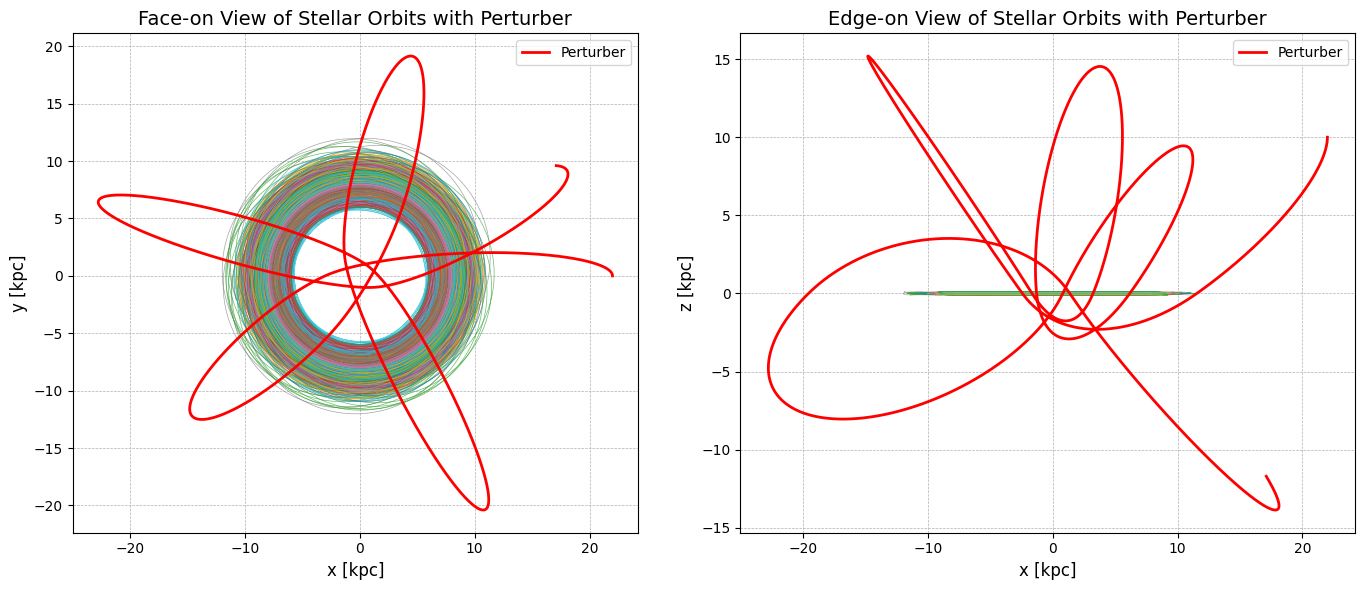

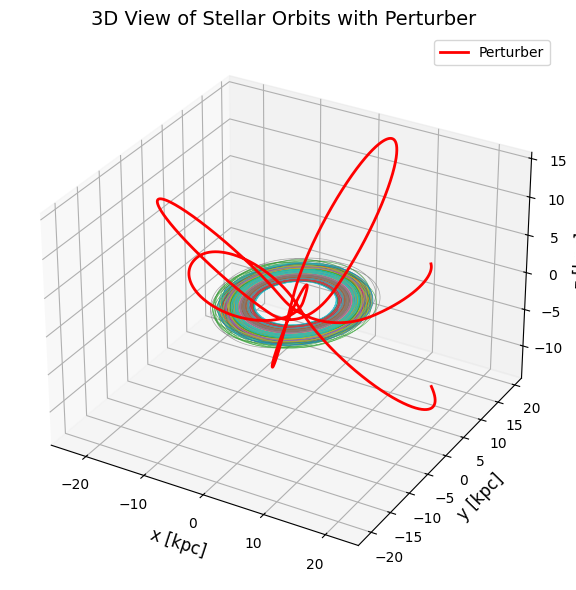

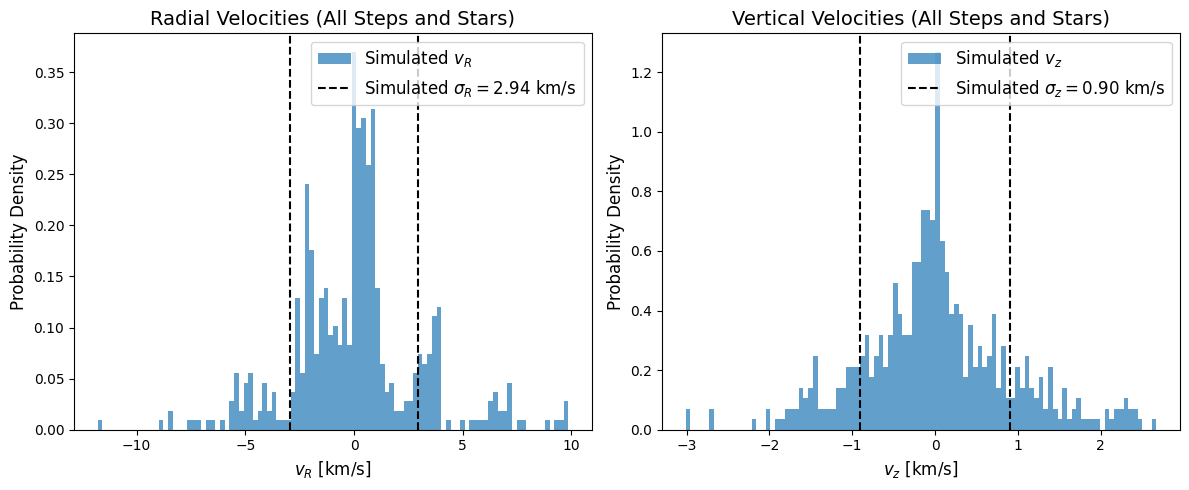

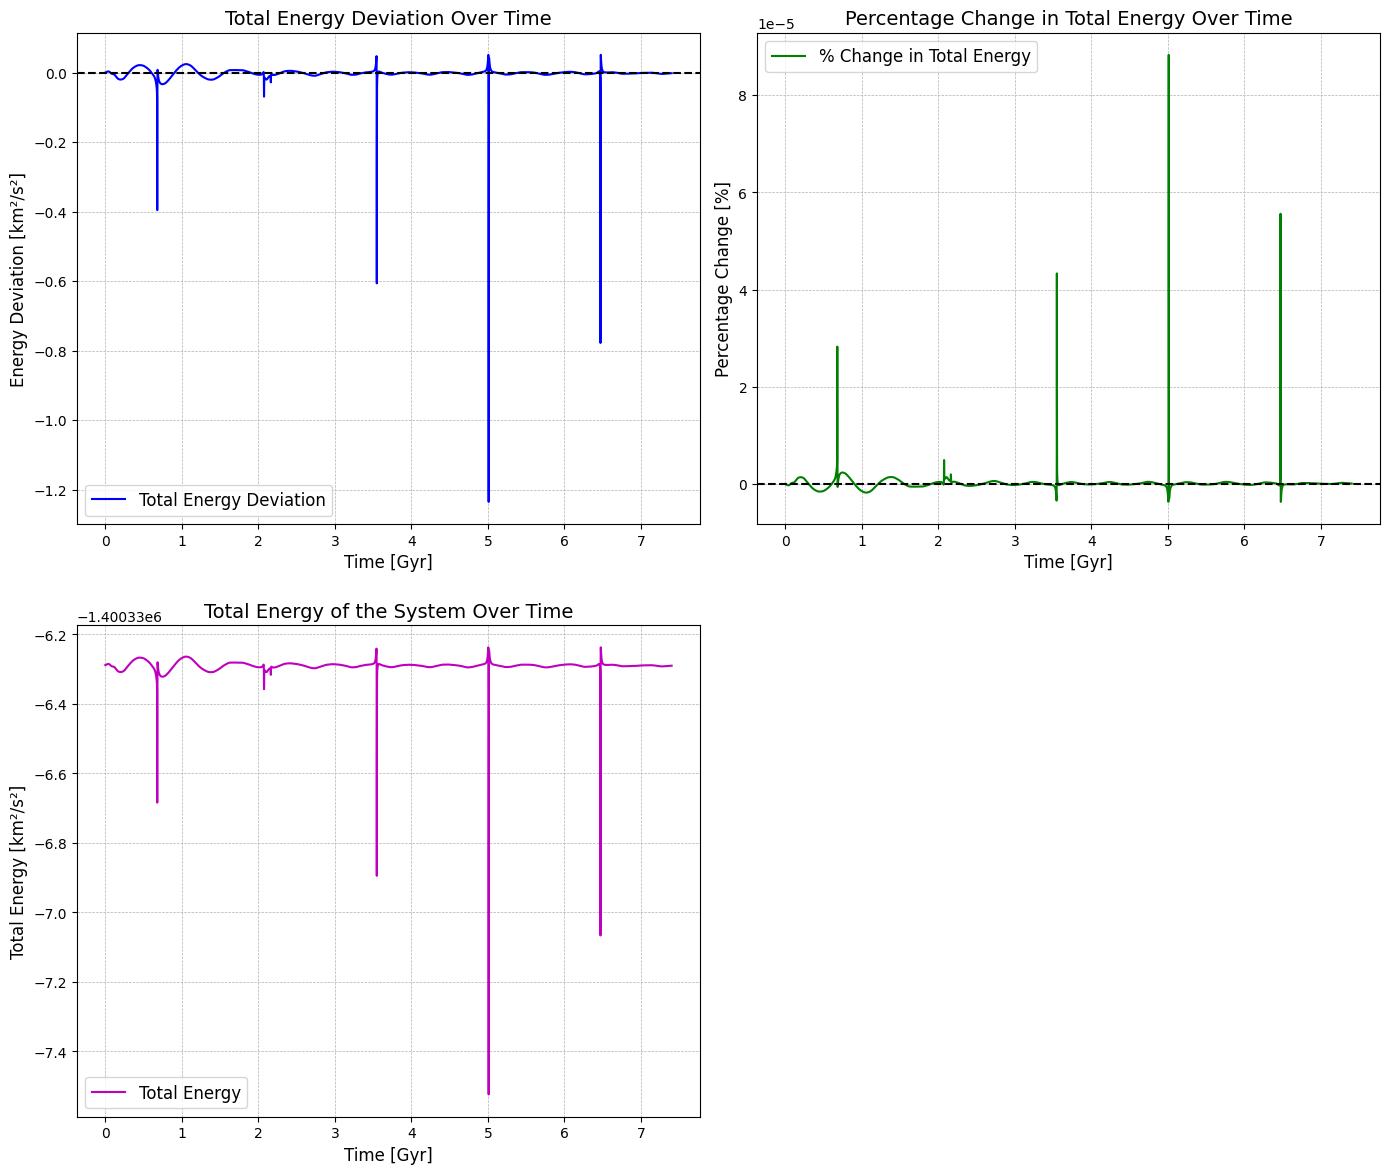

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# -------------------------------
# Physical Constants and Parameters
# -------------------------------

# Gravitational constant in kpc (km/s)^2 Msun^{-1}
G = 4.30091e-6  

# Miyamoto-Nagai potential parameters
M = 1e10        # Msun, mass of the galaxy
a = 2.5         # kpc, radial scale length
b = a / 20      # kpc, vertical scale height

# Perturber (MBH) parameters
MBH = 1e0      # Msun, mass of the perturber
epsilon = 0.01   # kpc, softening length to avoid singularities

# Simulation parameters
alpha = 0.05            # Small parameter controlling epicyclic amplitude
R_c = 8.0               # kpc, reference radius (e.g., Solar circle)
num_stars = 500         # Number of stars to simulate
num_steps_per_orbit = 5000  # Integration steps per orbit
num_orbits = 10        # Number of orbits to simulate

# Time parameters
Omega_c = np.sqrt(G * M / (R_c**2 + (a + b)**2)**(1.5))
T_orbit = 2 * np.pi / Omega_c
dt = T_orbit / num_steps_per_orbit
num_steps = int(num_steps_per_orbit * num_orbits)

# -------------------------------
# Potential and Gradient Definitions
# -------------------------------

def potential(R, z):
    """Compute the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    return -G * M / S

def gradient_potential(R, z):
    """Compute the gradient of the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    # Components of the gradient
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

def gradient_potential_vectorized(R, z):
    """Vectorized computation of the gradient of the potential at positions (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

# -------------------------------
# Frequency Definitions
# -------------------------------

def Omega(R):
    """Compute the circular angular speed Omega at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    return np.sqrt(G * M / S**3)

def kappa(R):
    """Compute the epicyclic frequency kappa at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    Omega_sq = G * M / S**3
    R_over_S_sq = (R / S)**2
    kappa_sq = Omega_sq * (-3 * R_over_S_sq + 4)
    return np.sqrt(kappa_sq)

def gamma(R):
    """Compute gamma = 2 * Omega / kappa at radius R."""
    return 2 * Omega(R) / kappa(R)

# -------------------------------
# Velocity Dispersion Functions
# -------------------------------

def sigma_R_squared(R):
    """Compute sigma_R^2 using Eq. (8)."""
    kappa_R = kappa(R)
    return (kappa_R * alpha * R)**2 / 3

def rho(R, z):
    """Compute the volume density at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    numerator = b**2 * M * (a * R**2 + (a + 3 * B) * (a + B)**2)
    denominator = 4 * np.pi * S**5 * B**3
    return numerator / denominator

def sigma_z_squared(R):
    """Compute sigma_z^2 using Eq. (10)."""
    return b**2 * G * rho(R, 0)

# -------------------------------
# Acceleration Functions
# -------------------------------

def accelerations_perturber(state):
    """Compute the acceleration for the perturber."""
    x, y, z = state[0], state[1], state[2]
    R = np.sqrt(x**2 + y**2)
    if R == 0:
        # Avoid division by zero at R = 0
        ax = 0.0
        ay = 0.0
    else:
        dPhi_dR, dPhi_dz = gradient_potential(R, z)
        # Convert gradient to Cartesian coordinates
        ax = -dPhi_dR * (x / R)
        ay = -dPhi_dR * (y / R)
    az = -dPhi_dz
    return np.array([ax, ay, az])

def accelerations_stars(states, state_BH):
    """Compute the accelerations for the stars."""
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    R = np.sqrt(x**2 + y**2)

    dPhi_dR, dPhi_dz = gradient_potential_vectorized(R, z)

    # Avoid division by zero at R = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        x_over_R = np.where(R != 0, x / R, 0)
        y_over_R = np.where(R != 0, y / R, 0)
        ax = -dPhi_dR * x_over_R
        ay = -dPhi_dR * y_over_R

    az = -dPhi_dz

    # Compute acceleration due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2

    with np.errstate(divide='ignore', invalid='ignore'):
        inv_r3 = 1.0 / (r_BH_sq * np.sqrt(r_BH_sq))
        a_BH_x = -G * MBH * dx * inv_r3
        a_BH_y = -G * MBH * dy * inv_r3
        a_BH_z = -G * MBH * dz * inv_r3

    # Total accelerations
    ax_total = ax + a_BH_x
    ay_total = ay + a_BH_y
    az_total = az + a_BH_z

    accelerations = np.zeros((len(x), 3))
    accelerations[:, 0] = ax_total
    accelerations[:, 1] = ay_total
    accelerations[:, 2] = az_total

    return accelerations

# -------------------------------
# Leapfrog Integrator Functions
# -------------------------------

def leapfrog_step_array(states, dt, accelerations_func, state_BH):
    """Perform one step of the leapfrog integrator (velocity Verlet) for arrays."""
    positions = states[:, :3]
    velocities = states[:, 3:6]

    # Compute acceleration at current positions
    accelerations = accelerations_func(states, state_BH)

    # Update positions
    positions_new = positions + velocities * dt + 0.5 * accelerations * dt**2

    # Prepare new states for acceleration computation
    states_new = np.zeros_like(states)
    states_new[:, :3] = positions_new
    states_new[:, 3:6] = velocities  # velocities will be updated later

    # Compute new accelerations at new positions
    accelerations_new = accelerations_func(states_new, state_BH)

    # Update velocities
    velocities_new = velocities + 0.5 * (accelerations + accelerations_new) * dt

    # Update states
    states[:, :3] = positions_new
    states[:, 3:6] = velocities_new

    return states

def leapfrog_step(state, dt, accelerations_func):
    """Perform one step of the leapfrog integrator (velocity Verlet) for the perturber."""
    positions = state[:3]
    velocities = state[3:6]

    # Compute acceleration at current position
    accelerations = accelerations_func(state)

    # Update positions
    positions_new = positions + velocities * dt + 0.5 * accelerations * dt**2

    # Prepare new state for acceleration computation
    state_new = np.zeros_like(state)
    state_new[:3] = positions_new
    state_new[3:6] = velocities  # velocities will be updated later

    # Compute new acceleration at new position
    accelerations_new = accelerations_func(state_new)

    # Update velocities
    velocities_new = velocities + 0.5 * (accelerations + accelerations_new) * dt

    # Update state
    state[:3] = positions_new
    state[3:6] = velocities_new

    return state

# -------------------------------
# Total Energy Calculation
# -------------------------------

def total_energy(states, state_BH):
    """
    Compute the total energy (kinetic + potential) for the stars and the perturber.

    Components:
    - Stars:
        - Kinetic Energy
        - Potential Energy from Galaxy
        - Potential Energy from Perturber
    - Perturber:
        - Kinetic Energy
        - Potential Energy from Galaxy
    """
    # Stars' positions and velocities
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    vx = states[:, 3]
    vy = states[:, 4]
    vz = states[:, 5]
    R = np.sqrt(x**2 + y**2)

    # Kinetic energy of stars (assuming unit mass)
    kinetic_energy_stars = 0.5 * (vx**2 + vy**2 + vz**2)

    # Potential energy from the Miyamoto-Nagai potential (galaxy)
    potential_energy_galaxy_stars = potential(R, z)

    # Potential energy due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2
    potential_energy_BH_stars = -G * MBH / np.sqrt(r_BH_sq)

    # Total potential energy for stars
    potential_energy_stars = potential_energy_galaxy_stars + potential_energy_BH_stars

    # Total energy for stars
    total_energy_stars = kinetic_energy_stars + potential_energy_stars

    # Perturber's kinetic energy
    vx_BH, vy_BH, vz_BH = state_BH[3], state_BH[4], state_BH[5]
    kinetic_energy_BH = 0.5 * (vx_BH**2 + vy_BH**2 + vz_BH**2)

    # Perturber's potential energy from the galaxy
    R_BH = np.sqrt(x_BH**2 + y_BH**2)
    potential_energy_galaxy_BH = potential(R_BH, z_BH)

    # Total energy for the perturber
    total_energy_BH = kinetic_energy_BH + potential_energy_galaxy_BH

    # Total energy of the system (stars + perturber)
    total_energy_system = np.sum(total_energy_stars) + total_energy_BH

    return total_energy_system

# -------------------------------
# Initial Conditions for Stars
# -------------------------------

# Compute frequencies and dispersions at reference radius
Omega_c = Omega(R_c)
kappa_c = kappa(R_c)
gamma_c = gamma(R_c)
sigma_R2 = sigma_R_squared(R_c)
sigma_z2 = sigma_z_squared(R_c)
v_circ_c = Omega_c * R_c

# Initialize arrays for stars' initial positions and velocities
x0 = np.zeros(num_stars)
y0 = np.zeros(num_stars)
z0 = np.zeros(num_stars)
vx0 = np.zeros(num_stars)
vy0 = np.zeros(num_stars)
vz0 = np.zeros(num_stars)

# Calculate sigma_R based on your definition
sigma_R = np.sqrt(sigma_R2)

for i in range(num_stars):
    # Random initial azimuthal angle
    phi = np.random.uniform(0, 2 * np.pi)
    
    # Random phase for epicyclic motion
    phi_x = np.random.uniform(0, 2 * np.pi)
    
    # Radial displacement sampled from a Gaussian distribution
    # x = (v_R / kappa) where v_R ~ N(0, sigma_R)
    v_R = np.random.normal(0.0, sigma_R)
    x = v_R / kappa_c
    
    # Actual radius
    R = R_c + x
    
    # Reduced azimuthal velocity based on equation (7)
    tilde_v_phi = (kappa_c**2 * x) / (2 * Omega_c)
    
    # Total azimuthal velocity
    v_phi = v_circ_c + tilde_v_phi
    
    # Sample v_z from normal distribution
    v_z = np.random.normal(0.0, np.sqrt(sigma_z2))
    
    # Compute Cartesian positions
    x0[i] = R * np.cos(phi)
    y0[i] = R * np.sin(phi)
    z0[i] = 0.0  # Start in the plane
    
    # Convert to Cartesian velocities
    vx0[i] = v_R * np.cos(phi) - v_phi * np.sin(phi)
    vy0[i] = v_R * np.sin(phi) + v_phi * np.cos(phi)
    vz0[i] = v_z

# Initial state arrays for stars
states = np.zeros((num_stars, 6))
states[:, 0] = x0
states[:, 1] = y0
states[:, 2] = z0
states[:, 3] = vx0
states[:, 4] = vy0
states[:, 5] = vz0

# -------------------------------
# Initial Conditions for Perturber
# -------------------------------

# Adjusted initial conditions for the perturber
x_BH0 = 22.0      # kpc
y_BH0 = 0.0       # kpc
z_BH0 = 10.0      # kpc, Start above the disk
vx_BH0 = 0.0      # km/s
vy_BH0 = 5.0      # km/s, For orthogonal passage, set vy_BH0 = 0.0
vz_BH0 = -10.0    # km/s, Increased speed for timely interaction

# State vector for the perturber: [x, y, z, vx, vy, vz]
state_BH = np.array([x_BH0, y_BH0, z_BH0, vx_BH0, vy_BH0, vz_BH0])

# -------------------------------
# Initial Energy Calculation
# -------------------------------

# Compute initial total energy
initial_total_energy = total_energy(states, state_BH)

# -------------------------------
# Arrays to Store Simulation Data
# -------------------------------

# Initialize arrays to store positions and velocities of stars
positions = np.zeros((num_steps, num_stars, 3))
velocities_all = np.zeros((num_steps, num_stars, 3))  # To store all velocities

# Initialize array to store total energy at each timestep
energies = np.zeros(num_steps)

# Initialize array to store perturber's positions
perturber_positions = np.zeros((num_steps, 3))

# Store initial positions, velocities, and energy
positions[0, :, :] = states[:, :3]
velocities_all[0, :, :] = states[:, 3:6]
energies[0] = initial_total_energy
perturber_positions[0] = state_BH[:3]

# -------------------------------
# Time Integration Loop
# -------------------------------

print("Integrating the system with the perturber...")
for t in tqdm(range(1, num_steps)):
    # Update the perturber's state using the leapfrog integrator
    state_BH = leapfrog_step(state_BH, dt, accelerations_perturber)

    # Store the perturber's position
    perturber_positions[t] = state_BH[:3]

    # Update the stars' states using the leapfrog integrator
    states = leapfrog_step_array(states, dt, accelerations_stars, state_BH)

    # Store positions and velocities
    positions[t, :, :] = states[:, :3]
    velocities_all[t, :, :] = states[:, 3:6]

    # Compute and store total energy of the system
    energies[t] = total_energy(states, state_BH)

# -------------------------------
# Velocity Dispersion Analysis
# -------------------------------

# Compute final velocity components at the last timestep
v_x_final = velocities_all[-1, :, 0]
v_y_final = velocities_all[-1, :, 1]
v_z_final = velocities_all[-1, :, 2]
x_final = positions[-1, :, 0]
y_final = positions[-1, :, 1]
z_final = positions[-1, :, 2]

# Correctly compute R for each star at the final timestep (Cylindrical radius)
R_final = np.sqrt(x_final**2 + y_final**2)

# Correctly compute radial velocity v_R for each star at the final timestep
with np.errstate(divide='ignore', invalid='ignore'):
    v_R_final = np.where(R_final != 0, (x_final * v_x_final + y_final * v_y_final) / R_final, 0)

# Vertical velocity remains the same
v_z_final = v_z_final

# Compute simulated dispersions from the final velocities
sigma_R_sim = np.std(v_R_final)
sigma_z_sim = np.std(v_z_final)

# Compute theoretical dispersions
sigma_R_theory = np.sqrt(sigma_R2)
sigma_z_theory = np.sqrt(sigma_z2)

print(f"\n--- Velocity Dispersion Analysis ---")
print(f"Simulated σ_R: {sigma_R_sim:.2f} km/s")
print(f"Theoretical σ_R: {sigma_R_theory:.2f} km/s")
print(f"Simulated σ_z: {sigma_z_sim:.2f} km/s")
print(f"Theoretical σ_z: {sigma_z_theory:.2f} km/s")


# -------------------------------
# Energy Conservation Analysis
# -------------------------------

# Compute the percentage change in total energy from the start
percentage_change_total_energy = 100 * (energies - initial_total_energy) / initial_total_energy

# -------------------------------
# Visualization
# -------------------------------

# Plotting the orbits (Face-on and Edge-on views)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Face-on view (x-y plane)
for i in range(num_stars):
    axes[0].plot(positions[:, i, 0], positions[:, i, 1], linewidth=0.5, alpha=0.7)
axes[0].plot(perturber_positions[:, 0], perturber_positions[:, 1], 'r-', linewidth=2, label='Perturber')
axes[0].set_xlabel('x [kpc]', fontsize=12)
axes[0].set_ylabel('y [kpc]', fontsize=12)
axes[0].set_title('Face-on View of Stellar Orbits with Perturber', fontsize=14)
axes[0].set_aspect('equal')
axes[0].grid(True, linestyle='--', linewidth=0.5)
axes[0].legend()

# Edge-on view (x-z plane)
for i in range(num_stars):
    axes[1].plot(positions[:, i, 0], positions[:, i, 2], linewidth=0.5, alpha=0.7)
axes[1].plot(perturber_positions[:, 0], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')
axes[1].set_xlabel('x [kpc]', fontsize=12)
axes[1].set_ylabel('z [kpc]', fontsize=12)
axes[1].set_title('Edge-on View of Stellar Orbits with Perturber', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

# 3D plot of the orbits (x, y, z for stars and perturber)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot star orbits in 3D
for i in range(num_stars):
    ax.plot(positions[:, i, 0], positions[:, i, 1], positions[:, i, 2], linewidth=0.5, alpha=0.7)

# Plot perturber's orbit in 3D
ax.plot(perturber_positions[:, 0], perturber_positions[:, 1], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')

# Set labels and title
ax.set_xlabel('x [kpc]', fontsize=12)
ax.set_ylabel('y [kpc]', fontsize=12)
ax.set_zlabel('z [kpc]', fontsize=12)
ax.set_title('3D View of Stellar Orbits with Perturber', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

# Plot histograms of all velocity components
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(v_R_final, bins=100, density=True, alpha=0.7, label='Simulated $v_R$')
plt.axvline(sigma_R_sim, color='k', linestyle='--', label=f'Simulated $σ_R = {sigma_R_sim:.2f}$ km/s')
plt.axvline(-sigma_R_sim, color='k', linestyle='--')
plt.title('Radial Velocities (All Steps and Stars)', fontsize=14)
plt.xlabel('$v_R$ [km/s]', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(v_z_final, bins=100, density=True, alpha=0.7, label='Simulated $v_z$')
plt.axvline(sigma_z_sim, color='k', linestyle='--', label=f'Simulated $σ_z = {sigma_z_sim:.2f}$ km/s')
plt.axvline(-sigma_z_sim, color='k', linestyle='--')
plt.title('Vertical Velocities (All Steps and Stars)', fontsize=14)
plt.xlabel('$v_z$ [km/s]', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Plotting energy conservation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Energy deviation over time
time = np.linspace(0, num_orbits * T_orbit, num_steps)
axes[0, 0].plot(time, energies - initial_total_energy, label='Total Energy Deviation', color='b')
axes[0, 0].set_title("Total Energy Deviation Over Time", fontsize=14)
axes[0, 0].set_xlabel("Time [Gyr]", fontsize=12)
axes[0, 0].set_ylabel("Energy Deviation [km²/s²]", fontsize=12)
axes[0, 0].grid(True, linestyle='--', linewidth=0.5)
axes[0, 0].axhline(0, color='k', linestyle='--')
axes[0, 0].legend(fontsize=12)

# Plot 2: Percentage change in total energy over time
axes[0, 1].plot(time, percentage_change_total_energy, label='% Change in Total Energy', color='g')
axes[0, 1].set_title("Percentage Change in Total Energy Over Time", fontsize=14)
axes[0, 1].set_xlabel("Time [Gyr]", fontsize=12)
axes[0, 1].set_ylabel("Percentage Change [%]", fontsize=12)
axes[0, 1].grid(True, linestyle='--', linewidth=0.5)
axes[0, 1].axhline(0, color='k', linestyle='--')
axes[0, 1].legend(fontsize=12)

# Plot 3: Total energy of the system over time
axes[1, 0].plot(time, energies, label='Total Energy', color='m')
axes[1, 0].set_title("Total Energy of the System Over Time", fontsize=14)
axes[1, 0].set_xlabel("Time [Gyr]", fontsize=12)
axes[1, 0].set_ylabel("Total Energy [km²/s²]", fontsize=12)
axes[1, 0].grid(True, linestyle='--', linewidth=0.5)
axes[1, 0].legend(fontsize=12)

# Plot 4: (Optional) Placeholder for additional energy-related plots
axes[1, 1].axis('off')  # Turn off the axis if not used

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


All stars are initially bound.
Integrating the system with the perturber...


100%|██████████| 49999/49999 [00:10<00:00, 4695.66it/s]



Removing any unbound stars after simulation...
All stars remain bound after simulation.

--- Velocity Dispersion Analysis ---
Simulated σ_R: 7.70 km/s
Theoretical σ_R: 3.86 km/s
Simulated σ_z: 0.90 km/s
Theoretical σ_z: 1.35 km/s


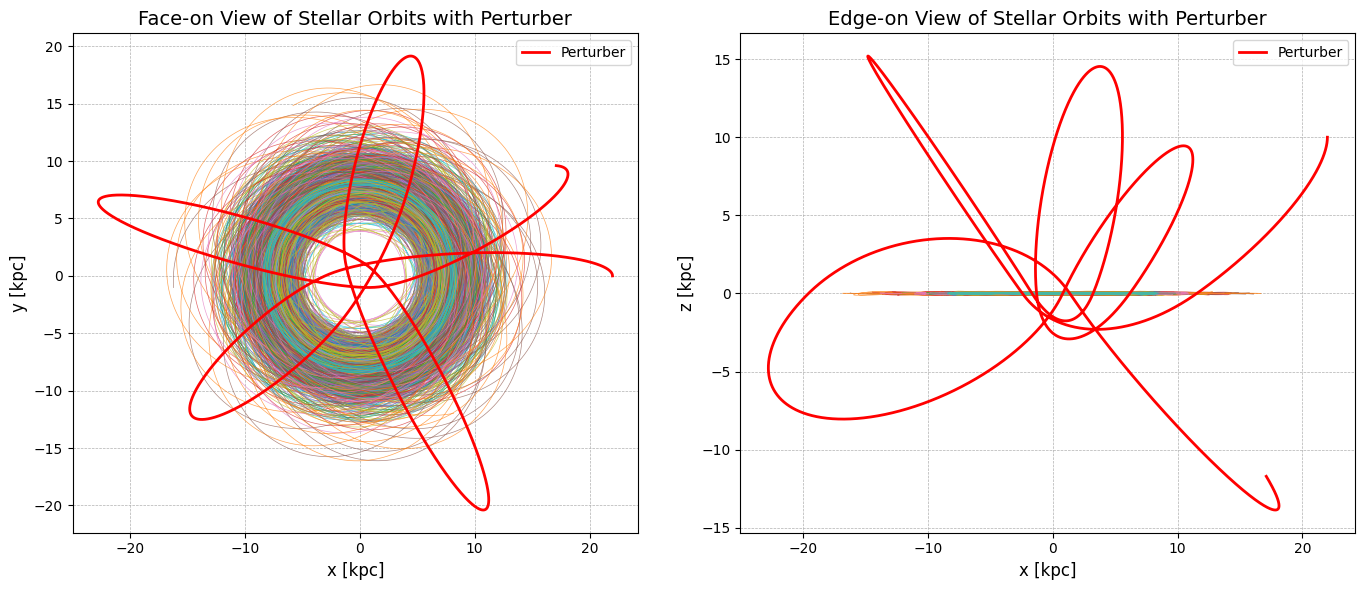

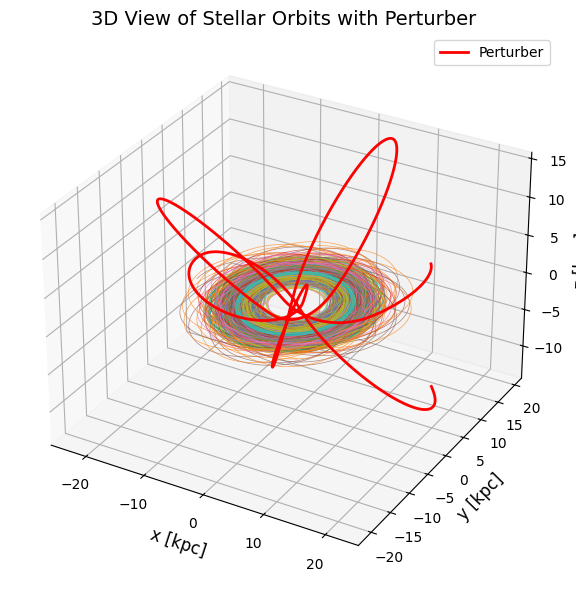

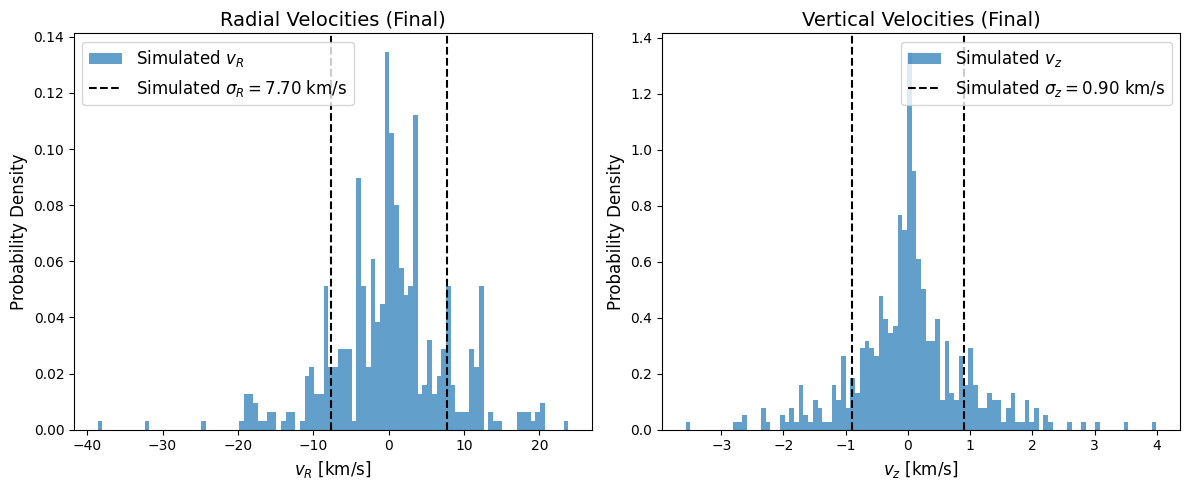

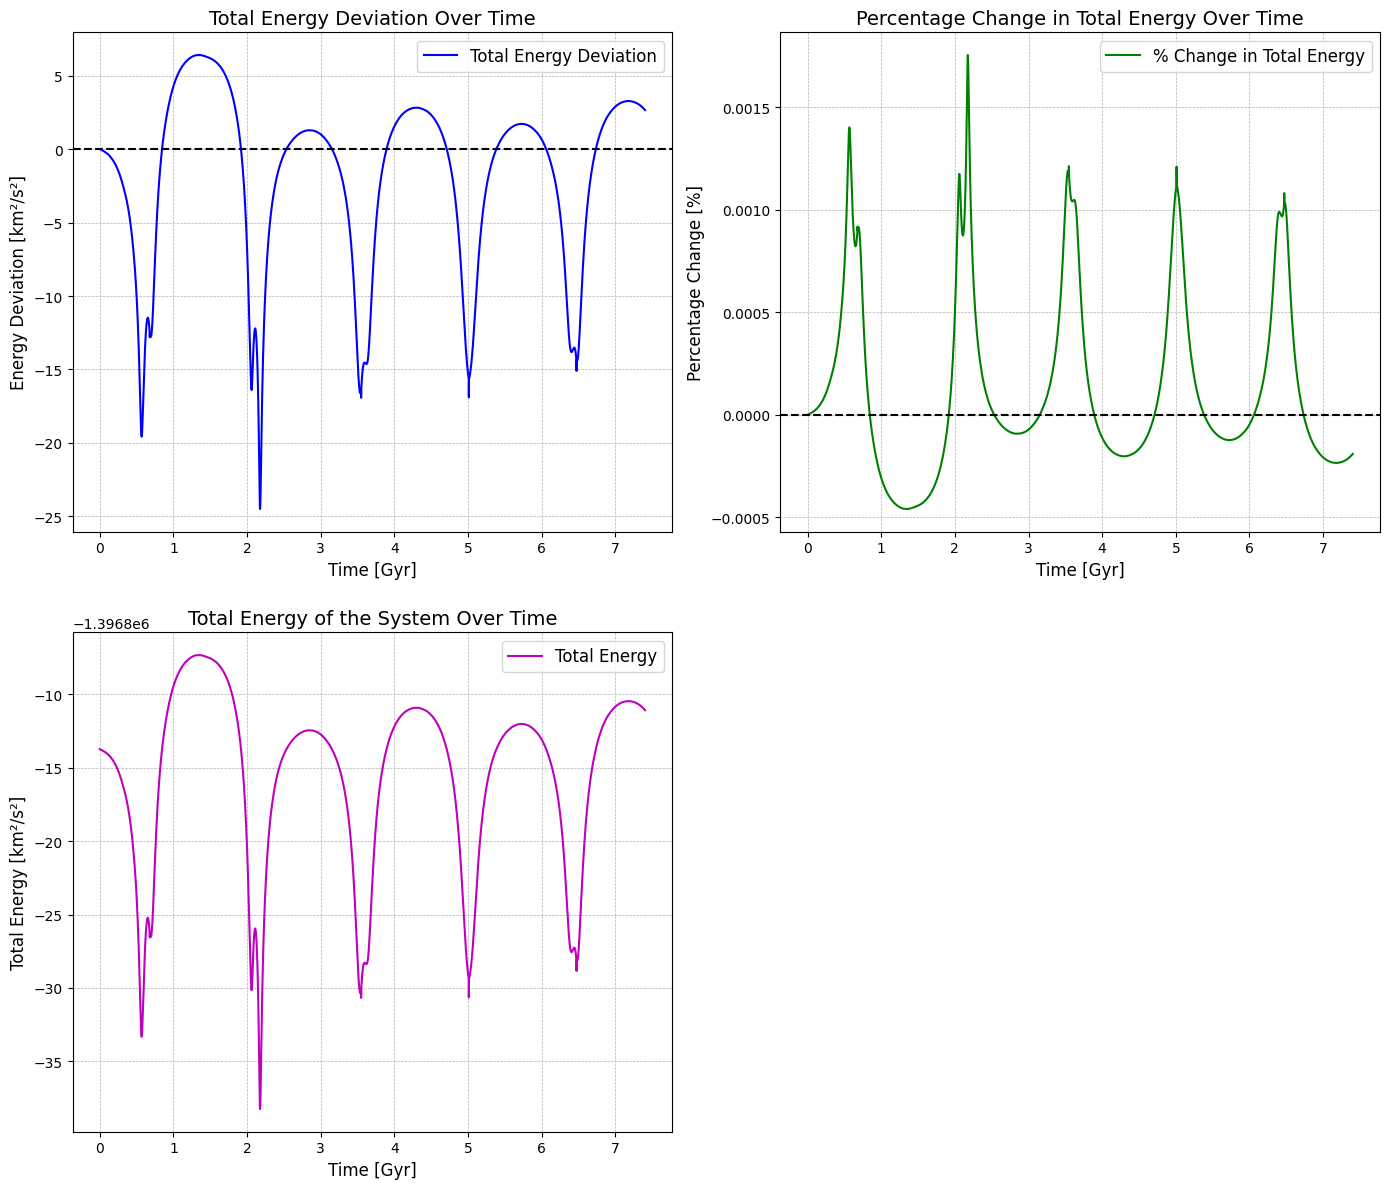

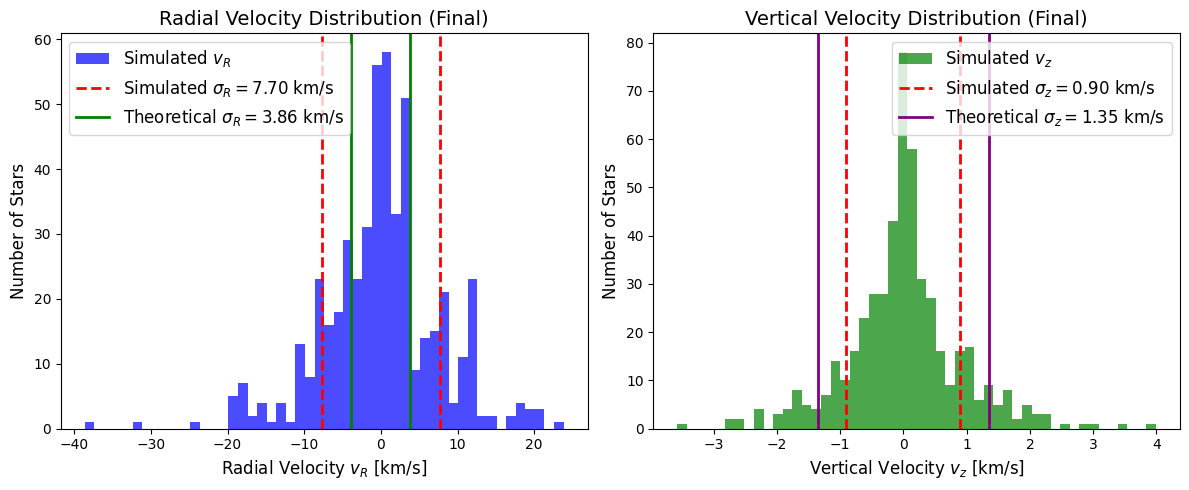


Simulation and analysis complete.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# -------------------------------
# Physical Constants and Parameters
# -------------------------------

# Gravitational constant in kpc (km/s)^2 Msun^{-1}
G = 4.30091e-6  

# Miyamoto-Nagai potential parameters
M = 1e10        # Msun, mass of the galaxy
a = 2.5         # kpc, radial scale length
b = a / 20      # kpc, vertical scale height

# Perturber (MBH) parameters
MBH = 1e5       # Msun, mass of the perturber (adjusted for significance)
epsilon = 0.01  # kpc, softening length to avoid singularities

# Simulation parameters
alpha = 0.05            # Small parameter controlling epicyclic amplitude
R_c = 8.0               # kpc, reference radius (e.g., Solar circle)
num_stars = 500         # Number of stars to simulate
num_steps_per_orbit = 5000  # Integration steps per orbit
num_orbits = 10         # Number of orbits to simulate

# Time parameters
Omega_c = np.sqrt(G * M / (R_c**2 + (a + b)**2)**(1.5))
T_orbit = 2 * np.pi / Omega_c
dt = T_orbit / num_steps_per_orbit
num_steps = int(num_steps_per_orbit * num_orbits)

# -------------------------------
# Potential and Gradient Definitions
# -------------------------------

def potential(R, z):
    """Compute the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    return -G * M / S

def gradient_potential(R, z):
    """Compute the gradient of the Miyamoto-Nagai potential at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    # Components of the gradient
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

def gradient_potential_vectorized(R, z):
    """Vectorized computation of the gradient of the potential at positions (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    dPhi_dR = G * M * R / S**3
    dPhi_dz = G * M * z * (a + B) / (S**3 * B)
    return dPhi_dR, dPhi_dz

# -------------------------------
# Frequency Definitions
# -------------------------------

def Omega(R):
    """Compute the circular angular speed Omega at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    return np.sqrt(G * M / S**3)

def kappa(R):
    """Compute the epicyclic frequency kappa at radius R."""
    S = np.sqrt(R**2 + (a + b)**2)
    Omega_sq = G * M / S**3
    R_over_S_sq = (R / S)**2
    kappa_sq = Omega_sq * (-3 * R_over_S_sq + 4)
    return np.sqrt(kappa_sq)

def gamma(R):
    """Compute gamma = 2 * Omega / kappa at radius R."""
    return 2.0 * Omega(R) / kappa(R)

# -------------------------------
# Velocity Dispersion Functions
# -------------------------------

def sigma_R_squared(R):
    """Compute sigma_R^2 using Eq. (8). Corrected to remove division by 3."""
    kappa_R = kappa(R)
    return (kappa_R * alpha * R)**2  # Removed division by 3

def rho(R, z):
    """Compute the volume density at position (R, z)."""
    B = np.sqrt(z**2 + b**2)
    S = np.sqrt(R**2 + (a + B)**2)
    numerator = b**2 * M * (a * R**2 + (a + 3 * B) * (a + B)**2)
    denominator = 4 * np.pi * S**5 * B**3
    return numerator / denominator

def sigma_z_squared(R):
    """Compute sigma_z^2 using Eq. (10)."""
    return b**2 * G * rho(R, 0)

# -------------------------------
# Acceleration Functions
# -------------------------------

def accelerations_perturber(state):
    """Compute the acceleration for the perturber."""
    x, y, z = state[0], state[1], state[2]
    R = np.sqrt(x**2 + y**2)
    if R == 0:
        # Avoid division by zero at R = 0
        ax = 0.0
        ay = 0.0
    else:
        dPhi_dR, dPhi_dz = gradient_potential(R, z)
        # Convert gradient to Cartesian coordinates
        ax = -dPhi_dR * (x / R)
        ay = -dPhi_dR * (y / R)
    az = -dPhi_dz
    return np.array([ax, ay, az])

def accelerations_stars(states, state_BH):
    """Compute the accelerations for the stars."""
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    R = np.sqrt(x**2 + y**2)

    dPhi_dR, dPhi_dz = gradient_potential_vectorized(R, z)

    # Avoid division by zero at R = 0
    with np.errstate(divide='ignore', invalid='ignore'):
        x_over_R = np.where(R != 0, x / R, 0.0)
        y_over_R = np.where(R != 0, y / R, 0.0)
        a_x = -dPhi_dR * x_over_R
        a_y = -dPhi_dR * y_over_R

    a_z = -dPhi_dz

    # Compute acceleration due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2

    with np.errstate(divide='ignore', invalid='ignore'):
        inv_r3 = 1.0 / (r_BH_sq * np.sqrt(r_BH_sq))
        a_BH_x = -G * MBH * dx * inv_r3
        a_BH_y = -G * MBH * dy * inv_r3
        a_BH_z = -G * MBH * dz * inv_r3

    # Total accelerations
    ax_total = a_x + a_BH_x
    ay_total = a_y + a_BH_y
    az_total = a_z + a_BH_z

    accelerations = np.zeros((len(x), 3))
    accelerations[:, 0] = ax_total
    accelerations[:, 1] = ay_total
    accelerations[:, 2] = az_total

    return accelerations

# -------------------------------
# Leapfrog Integrator Functions
# -------------------------------

def leapfrog_step_array(states, dt, accelerations_func, state_BH):
    """Perform one step of the leapfrog integrator (velocity Verlet) for arrays."""
    positions = states[:, :3]
    velocities = states[:, 3:6]

    # Compute acceleration at current positions
    accelerations = accelerations_func(states, state_BH)

    # Update positions
    positions_new = positions + velocities * dt + 0.5 * accelerations * dt**2

    # Prepare new states for acceleration computation
    states_new = np.zeros_like(states)
    states_new[:, :3] = positions_new
    states_new[:, 3:6] = velocities  # velocities will be updated later

    # Compute new accelerations at new positions
    accelerations_new = accelerations_func(states_new, state_BH)

    # Update velocities
    velocities_new = velocities + 0.5 * (accelerations + accelerations_new) * dt

    # Update states
    states[:, :3] = positions_new
    states[:, 3:6] = velocities_new

    return states

def leapfrog_step(state, dt, accelerations_func):
    """Perform one step of the leapfrog integrator (velocity Verlet) for the perturber."""
    positions = state[:3]
    velocities = state[3:6]

    # Compute acceleration at current position
    accelerations = accelerations_func(state)

    # Update positions
    positions_new = positions + velocities * dt + 0.5 * accelerations * dt**2

    # Prepare new state for acceleration computation
    state_new = np.zeros_like(state)
    state_new[:3] = positions_new
    state_new[3:6] = velocities  # velocities will be updated later

    # Compute new acceleration at new position
    accelerations_new = accelerations_func(state_new)

    # Update velocities
    velocities_new = velocities + 0.5 * (accelerations + accelerations_new) * dt

    # Update state
    state[:3] = positions_new
    state[3:6] = velocities_new

    return state

# -------------------------------
# Total Energy Calculation
# -------------------------------

def total_energy(states, state_BH):
    """
    Compute the total energy (kinetic + potential) for the stars and the perturber.

    Components:
    - Stars:
        - Kinetic Energy
        - Potential Energy from Galaxy
        - Potential Energy from Perturber
    - Perturber:
        - Kinetic Energy
        - Potential Energy from Galaxy
    """
    # Stars' positions and velocities
    x = states[:, 0]
    y = states[:, 1]
    z = states[:, 2]
    vx = states[:, 3]
    vy = states[:, 4]
    vz = states[:, 5]
    R = np.sqrt(x**2 + y**2)

    # Kinetic energy of stars (assuming unit mass)
    kinetic_energy_stars = 0.5 * (vx**2 + vy**2 + vz**2)

    # Potential energy from the Miyamoto-Nagai potential (galaxy)
    potential_energy_galaxy_stars = potential(R, z)

    # Potential energy due to the perturber with softening
    x_BH, y_BH, z_BH = state_BH[0], state_BH[1], state_BH[2]
    dx = x - x_BH
    dy = y - y_BH
    dz = z - z_BH
    r_BH_sq = dx**2 + dy**2 + dz**2 + epsilon**2
    potential_energy_BH_stars = -G * MBH / np.sqrt(r_BH_sq)

    # Total potential energy for stars
    potential_energy_stars = potential_energy_galaxy_stars + potential_energy_BH_stars

    # Total energy for stars
    total_energy_stars = kinetic_energy_stars + potential_energy_stars

    # Perturber's kinetic energy
    vx_BH, vy_BH, vz_BH = state_BH[3], state_BH[4], state_BH[5]
    kinetic_energy_BH = 0.5 * (vx_BH**2 + vy_BH**2 + vz_BH**2)

    # Perturber's potential energy from the galaxy
    R_BH = np.sqrt(x_BH**2 + y_BH**2)
    potential_energy_galaxy_BH = potential(R_BH, z_BH)

    # Total energy for the perturber
    total_energy_BH = kinetic_energy_BH + potential_energy_galaxy_BH

    # Total energy of the system (stars + perturber)
    total_energy_system = np.sum(total_energy_stars) + total_energy_BH

    return total_energy_system

# -------------------------------
# Initial Conditions for Stars
# -------------------------------

# Compute frequencies and dispersions at reference radius
Omega_c = Omega(R_c)
kappa_c = kappa(R_c)
gamma_c = gamma(R_c)
sigma_R2 = sigma_R_squared(R_c)
sigma_z2 = sigma_z_squared(R_c)
v_circ_c = Omega_c * R_c

# Initialize arrays for stars' initial positions and velocities
x0 = np.zeros(num_stars)
y0 = np.zeros(num_stars)
z0 = np.zeros(num_stars)
vx0 = np.zeros(num_stars)
vy0 = np.zeros(num_stars)
vz0 = np.zeros(num_stars)

# Calculate sigma_R based on your definition
sigma_R = np.sqrt(sigma_R2)
sigma_z = np.sqrt(sigma_z2)

for i in range(num_stars):
    # Random initial azimuthal angle
    phi = np.random.uniform(0, 2 * np.pi)
    
    # Radial velocity sampled from a Gaussian distribution
    v_R = np.random.normal(0.0, sigma_R)
    
    # Radial displacement based on epicyclic approximation
    x = v_R / kappa_c
    
    # Actual radius
    R = R_c + x
    
    # Correct azimuthal velocity based on epicyclic approximation
    tilde_v_phi = (kappa_c**2 * x) / (2 * Omega_c)
    
    # Total azimuthal velocity (corrected formula)
    v_phi = v_circ_c - 2.0 * Omega_c * v_R / kappa_c  # Corrected sign
    
    # Sample v_z from normal distribution
    v_z = np.random.normal(0.0, sigma_z)
    
    # Compute Cartesian positions
    x0[i] = R * np.cos(phi)
    y0[i] = R * np.sin(phi)
    z0[i] = 0.0  # Start in the plane
    
    # Convert to Cartesian velocities
    vx0[i] = v_R * np.cos(phi) - v_phi * np.sin(phi)
    vy0[i] = v_R * np.sin(phi) + v_phi * np.cos(phi)
    vz0[i] = v_z

# Initial state arrays for stars
states = np.zeros((num_stars, 6))
states[:, 0] = x0
states[:, 1] = y0
states[:, 2] = z0
states[:, 3] = vx0
states[:, 4] = vy0
states[:, 5] = vz0

# -------------------------------
# Initial Conditions for Perturber
# -------------------------------

# Adjusted initial conditions for the perturber
x_BH0 = 22.0      # kpc
y_BH0 = 0.0       # kpc
z_BH0 = 10.0      # kpc, Start above the disk
vx_BH0 = 0.0      # km/s
vy_BH0 = 5.0      # km/s, For orthogonal passage, set vy_BH0 = 0.0
vz_BH0 = -10.0    # km/s, Increased speed for timely interaction

# State vector for the perturber: [x, y, z, vx, vy, vz]
state_BH = np.array([x_BH0, y_BH0, z_BH0, vx_BH0, vy_BH0, vz_BH0])

# -------------------------------
# Initial Energy Calculation
# -------------------------------

# Compute initial total energy
initial_total_energy = total_energy(states, state_BH)

# -------------------------------
# Arrays to Store Simulation Data
# -------------------------------

# Initialize arrays to store positions and velocities of stars
positions = np.zeros((num_steps, num_stars, 3))
velocities_all = np.zeros((num_steps, num_stars, 3))  # To store all velocities

# Initialize array to store total energy at each timestep
energies = np.zeros(num_steps)

# Initialize array to store perturber's positions
perturber_positions = np.zeros((num_steps, 3))

# Store initial positions, velocities, and energy
positions[0, :, :] = states[:, :3]
velocities_all[0, :, :] = states[:, 3:6]
energies[0] = initial_total_energy
perturber_positions[0] = state_BH[:3]

# -------------------------------
# Initial Energy Check and Removal of Unbound Stars
# -------------------------------

def verify_initial_energy(states, state_BH):
    """Verify that all stars have E <= 0 initially."""
    R = np.sqrt(states[:, 0]**2 + states[:, 1]**2)
    Phi = potential(R, states[:, 2])
    v_sq = states[:, 3]**2 + states[:, 4]**2 + states[:, 5]**2
    E = 0.5 * v_sq + Phi
    bound_mask = E <= 0.0
    n_unbound = np.sum(~bound_mask)
    if n_unbound > 0:
        print(f"Removing {n_unbound} unbound stars initially.")
        # Remove unbound stars
        states = states[bound_mask]
        print(f"Number of stars after removal: {states.shape[0]}")
    else:
        print("All stars are initially bound.")
    return states

# Apply initial energy verification
states = verify_initial_energy(states, state_BH)
num_stars = states.shape[0]  # Update number of stars after removal

# Update simulation arrays based on the reduced number of stars
positions = positions[:, :num_stars, :]
velocities_all = velocities_all[:, :num_stars, :]

# -------------------------------
# Numerical Integration Loop
# -------------------------------

print("Integrating the system with the perturber...")
for t in tqdm(range(1, num_steps)):
    # Update the perturber's state using the leapfrog integrator
    state_BH = leapfrog_step(state_BH, dt, accelerations_perturber)

    # Store the perturber's position
    perturber_positions[t] = state_BH[:3]

    # Update the stars' states using the leapfrog integrator
    states = leapfrog_step_array(states, dt, accelerations_stars, state_BH)

    # Store positions and velocities
    positions[t, :, :] = states[:, :3]
    velocities_all[t, :, :] = states[:, 3:6]

    # Compute and store total energy of the system
    energies[t] = total_energy(states, state_BH)

# -------------------------------
# Final Energy Check and Removal of Unbound Stars
# -------------------------------

print("\nRemoving any unbound stars after simulation...")
def verify_final_energy(states, state_BH):
    """Verify that all stars have E <= 0 after simulation."""
    R = np.sqrt(states[:, 0]**2 + states[:, 1]**2)
    Phi = potential(R, states[:, 2])
    v_sq = states[:, 3]**2 + states[:, 4]**2 + states[:, 5]**2
    E = 0.5 * v_sq + Phi
    bound_mask = E <= 0.0
    n_unbound = np.sum(~bound_mask)
    if n_unbound > 0:
        print(f"Removing {n_unbound} unbound stars after simulation.")
        # Remove unbound stars
        states = states[bound_mask]
        print(f"Number of stars after removal: {states.shape[0]}")
    else:
        print("All stars remain bound after simulation.")
    return states

# Apply final energy verification
states = verify_final_energy(states, state_BH)

# Update simulation arrays based on the reduced number of stars
num_stars = states.shape[0]
positions = positions[:, :num_stars, :]
velocities_all = velocities_all[:, :num_stars, :]

# -------------------------------
# Velocity Dispersion Analysis
# -------------------------------

if num_stars > 0:
    # Compute final velocity components at the last timestep
    v_x_final = velocities_all[-1, :, 0]
    v_y_final = velocities_all[-1, :, 1]
    v_z_final = velocities_all[-1, :, 2]
    x_final = positions[-1, :, 0]
    y_final = positions[-1, :, 1]
    z_final = positions[-1, :, 2]

    # Correctly compute R for each star at the final timestep (Cylindrical radius)
    R_final = np.sqrt(x_final**2 + y_final**2)

    # Correctly compute radial velocity v_R for each star at the final timestep
    with np.errstate(divide='ignore', invalid='ignore'):
        v_R_final = np.where(R_final != 0, (x_final * v_x_final + y_final * v_y_final) / R_final, 0)

    # Vertical velocity remains the same
    v_z_final = v_z_final

    # Compute simulated dispersions from the final velocities
    sigma_R_sim = np.std(v_R_final)
    sigma_z_sim = np.std(v_z_final)

    # Compute theoretical dispersions
    sigma_R_theory = np.sqrt(sigma_R2)
    sigma_z_theory = np.sqrt(sigma_z2)

    print(f"\n--- Velocity Dispersion Analysis ---")
    print(f"Simulated σ_R: {sigma_R_sim:.2f} km/s")
    print(f"Theoretical σ_R: {sigma_R_theory:.2f} km/s")
    print(f"Simulated σ_z: {sigma_z_sim:.2f} km/s")
    print(f"Theoretical σ_z: {sigma_z_theory:.2f} km/s")
else:
    print("\nNo stars remain bound after simulation. Cannot compute velocity dispersions.")

# -------------------------------
# Energy Conservation Analysis
# -------------------------------

# Compute the percentage change in total energy from the start
percentage_change_total_energy = 100 * (energies - initial_total_energy) / initial_total_energy

# -------------------------------
# Visualization
# -------------------------------

if num_stars > 0:
    # Plotting the orbits (Face-on and Edge-on views)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Face-on view (x-y plane)
    for i in range(num_stars):
        axes[0].plot(positions[:, i, 0], positions[:, i, 1], linewidth=0.5, alpha=0.7)
    axes[0].plot(perturber_positions[:, 0], perturber_positions[:, 1], 'r-', linewidth=2, label='Perturber')
    axes[0].set_xlabel('x [kpc]', fontsize=12)
    axes[0].set_ylabel('y [kpc]', fontsize=12)
    axes[0].set_title('Face-on View of Stellar Orbits with Perturber', fontsize=14)
    axes[0].set_aspect('equal')
    axes[0].grid(True, linestyle='--', linewidth=0.5)
    axes[0].legend()

    # Edge-on view (x-z plane)
    for i in range(num_stars):
        axes[1].plot(positions[:, i, 0], positions[:, i, 2], linewidth=0.5, alpha=0.7)
    axes[1].plot(perturber_positions[:, 0], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')
    axes[1].set_xlabel('x [kpc]', fontsize=12)
    axes[1].set_ylabel('z [kpc]', fontsize=12)
    axes[1].set_title('Edge-on View of Stellar Orbits with Perturber', fontsize=14)
    axes[1].grid(True, linestyle='--', linewidth=0.5)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # 3D plot of the orbits (x, y, z for stars and perturber)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot star orbits in 3D
    for i in range(num_stars):
        ax.plot(positions[:, i, 0], positions[:, i, 1], positions[:, i, 2], linewidth=0.5, alpha=0.7)

    # Plot perturber's orbit in 3D
    ax.plot(perturber_positions[:, 0], perturber_positions[:, 1], perturber_positions[:, 2], 'r-', linewidth=2, label='Perturber')

    # Set labels and title
    ax.set_xlabel('x [kpc]', fontsize=12)
    ax.set_ylabel('y [kpc]', fontsize=12)
    ax.set_zlabel('z [kpc]', fontsize=12)
    ax.set_title('3D View of Stellar Orbits with Perturber', fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Plot histograms of all velocity components
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(v_R_final, bins=100, density=True, alpha=0.7, label='Simulated $v_R$')
    plt.axvline(sigma_R_sim, color='k', linestyle='--', label=f'Simulated $σ_R = {sigma_R_sim:.2f}$ km/s')
    plt.axvline(-sigma_R_sim, color='k', linestyle='--')
    plt.title('Radial Velocities (Final)', fontsize=14)
    plt.xlabel('$v_R$ [km/s]', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=12)

    plt.subplot(1, 2, 2)
    plt.hist(v_z_final, bins=100, density=True, alpha=0.7, label='Simulated $v_z$')
    plt.axvline(sigma_z_sim, color='k', linestyle='--', label=f'Simulated $σ_z = {sigma_z_sim:.2f}$ km/s')
    plt.axvline(-sigma_z_sim, color='k', linestyle='--')
    plt.title('Vertical Velocities (Final)', fontsize=14)
    plt.xlabel('$v_z$ [km/s]', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    # Plotting energy conservation
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Energy deviation over time
    time = np.linspace(0, num_orbits * T_orbit, num_steps)
    axes[0, 0].plot(time, energies - initial_total_energy, label='Total Energy Deviation', color='b')
    axes[0, 0].set_title("Total Energy Deviation Over Time", fontsize=14)
    axes[0, 0].set_xlabel("Time [Gyr]", fontsize=12)
    axes[0, 0].set_ylabel("Energy Deviation [km²/s²]", fontsize=12)
    axes[0, 0].grid(True, linestyle='--', linewidth=0.5)
    axes[0, 0].axhline(0, color='k', linestyle='--')
    axes[0, 0].legend(fontsize=12)

    # Plot 2: Percentage change in total energy over time
    percentage_change_total_energy = 100 * (energies - initial_total_energy) / initial_total_energy
    axes[0, 1].plot(time, percentage_change_total_energy, label='% Change in Total Energy', color='g')
    axes[0, 1].set_title("Percentage Change in Total Energy Over Time", fontsize=14)
    axes[0, 1].set_xlabel("Time [Gyr]", fontsize=12)
    axes[0, 1].set_ylabel("Percentage Change [%]", fontsize=12)
    axes[0, 1].grid(True, linestyle='--', linewidth=0.5)
    axes[0, 1].axhline(0, color='k', linestyle='--')
    axes[0, 1].legend(fontsize=12)

    # Plot 3: Total energy of the system over time
    axes[1, 0].plot(time, energies, label='Total Energy', color='m')
    axes[1, 0].set_title("Total Energy of the System Over Time", fontsize=14)
    axes[1, 0].set_xlabel("Time [Gyr]", fontsize=12)
    axes[1, 0].set_ylabel("Total Energy [km²/s²]", fontsize=12)
    axes[1, 0].grid(True, linestyle='--', linewidth=0.5)
    axes[1, 0].legend(fontsize=12)

    # Plot 4: Placeholder for additional energy-related plots
    axes[1, 1].axis('off')  # Turn off the axis if not used

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Plot final velocity dispersions comparison
    plt.figure(figsize=(12, 5))

    # Radial Velocity Dispersion
    plt.subplot(1, 2, 1)
    plt.hist(v_R_final, bins=50, alpha=0.7, color='blue', label='Simulated $v_R$')
    plt.axvline(sigma_R_sim, color='red', linestyle='--', linewidth=2, label=f'Simulated $σ_R = {sigma_R_sim:.2f}$ km/s')
    plt.axvline(-sigma_R_sim, color='red', linestyle='--', linewidth=2)
    plt.axvline(sigma_R_theory, color='green', linestyle='-', linewidth=2, label=f'Theoretical $σ_R = {sigma_R_theory:.2f}$ km/s')
    plt.axvline(-sigma_R_theory, color='green', linestyle='-', linewidth=2)
    plt.xlabel('Radial Velocity $v_R$ [km/s]', fontsize=12)
    plt.ylabel('Number of Stars', fontsize=12)
    plt.title('Radial Velocity Distribution (Final)', fontsize=14)
    plt.legend(fontsize=12)

    # Vertical Velocity Dispersion
    plt.subplot(1, 2, 2)
    plt.hist(v_z_final, bins=50, alpha=0.7, color='green', label='Simulated $v_z$')
    plt.axvline(sigma_z_sim, color='red', linestyle='--', linewidth=2, label=f'Simulated $σ_z = {sigma_z_sim:.2f}$ km/s')
    plt.axvline(-sigma_z_sim, color='red', linestyle='--', linewidth=2)
    plt.axvline(sigma_z_theory, color='purple', linestyle='-', linewidth=2, label=f'Theoretical $σ_z = {sigma_z_theory:.2f}$ km/s')
    plt.axvline(-sigma_z_theory, color='purple', linestyle='-', linewidth=2)
    plt.xlabel('Vertical Velocity $v_z$ [km/s]', fontsize=12)
    plt.ylabel('Number of Stars', fontsize=12)
    plt.title('Vertical Velocity Distribution (Final)', fontsize=14)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    print("\nSimulation and analysis complete.")
else:
    print("\nNo stars remain bound after simulation. Cannot perform further analysis.")
